# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 1 in Shi Jin's paper (2008-jy-phase.pdf):
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = e^{-25x^2}, \ S_0(x) = -0.2\log(2\cosh(5x)).
$$

Periodic BC.

Domain: $[-0.25, 0.25]\times [0, 0.5]$.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25x^2}\cos(-0.2\log(2\cosh(5x))/\varepsilon), \ q(x, 0) = e^{-25x^2}\sin(-0.2\log(2\cosh(5x))/\varepsilon),
$$
and bc
$$
p(x_0, t) = p(x_1, t), q(x_0, t) = q(x_1, t), p_x(x_0, t) = p_x(x_1, t), q_x(x_0, t) = q_x(x_1, t).
$$

---

However, 
$$
p_x, q_x
$$
are odd functions.

In [1]:
NAME = "1"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [2] + [32]*2 + [2] # (x, t) -> (u, v)
# layers = [2] + [32]*2 + [2]
c0 = 6.0
# w0 = jnp.array([[1.0, 1.0]]).T # (w_x, w_t)
w0 = jnp.array([[1.0, 1.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_u, w_v)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)
# direct_params = init_tanh_params(subkey, layers)

domain = jnp.array([[-0.25, 0.], [0.25, 0.5]])
spatial_width = domain[1, 0]-domain[0, 0]

epsilon = 1.0
V = 10.0

@jax.jit
def model(params, xt): # for derivatives
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mse

static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

# jacobian[i] = [[du/dx, du/dt],
#                [dv/dx, dv/dt]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, neumann, bc = batch["collocation"], batch["dirichlet"], batch["neumann"], batch["bc"]
	direct_params = params
	
	if collocation[0] is not None:
		uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
		u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
		duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
		du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
		duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
		du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0]
		loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
		loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
		loss_c = loss_c1 + loss_c2
	else:
		loss_c = 0.0
        
	if dirichlet[0] is not None:
		uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
		u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
		loss_d1 = metaloss(u_d, dirichlet.u)
		loss_d2 = metaloss(v_d, dirichlet.v)
		loss_d = loss_d1 + loss_d2
	else:
		loss_d = 0.0
	
	if neumann[0] is not None:
		duv_dxt_n = jacobian(direct_params, jnp.hstack([neumann.x, neumann.t]))
		du_dt_n, dv_dt_n = duv_dxt_n[:, 0:1, 1], duv_dxt_n[:, 1:2, 1]
		du_dx_n, dv_dx_n = duv_dxt_n[:, 0:1, 0], duv_dxt_n[:, 1:2, 0]
		duv_dxxtt_n = hessian(direct_params, jnp.hstack([neumann.x, neumann.t]))
		du_dxx_n, dv_dxx_n = duv_dxxtt_n[:, 0:1, 0, 0], duv_dxxtt_n[:, 1:2, 0, 0]
		loss_n_t1 = metaloss(du_dt_n, neumann.du_dt)
		loss_n_t2 = metaloss(dv_dt_n, neumann.dv_dt)
		loss_n_x1 = metaloss(du_dx_n, neumann.du_dx)
		loss_n_x2 = metaloss(dv_dx_n, neumann.dv_dx)
		loss_n_xx1 = metaloss(du_dxx_n, neumann.du_dxx)
		loss_n_xx2 = metaloss(dv_dxx_n, neumann.dv_dxx)
		loss_nt = loss_n_t1 + loss_n_t2
		loss_nx = loss_n_x1 + loss_n_x2
		loss_nxx = loss_n_xx1 + loss_n_xx2
	else:
		loss_nt = loss_nx = loss_nxx = 0.0
		
	if bc[0] is not None:
		uv_l = model(direct_params, jnp.hstack([bc.l, bc.t]))
		uv_r = model(direct_params, jnp.hstack([bc.r, bc.t]))
		u_l, v_l, u_r, v_r = uv_l[:, 0:1], uv_l[:, 1:2], uv_r[:, 0:1], uv_r[:, 1:2]
		duv_dxt_l = jacobian(direct_params, jnp.hstack([bc.l, bc.t]))
		duv_dxt_r = jacobian(direct_params, jnp.hstack([bc.r, bc.t]))
		du_dx_l, dv_dx_l = duv_dxt_l[:, 0:1, 0], duv_dxt_l[:, 1:2, 0]
		du_dx_r, dv_dx_r = duv_dxt_r[:, 0:1, 0], duv_dxt_r[:, 1:2, 0]
		loss_bcd = metaloss(u_l, u_r) + metaloss(v_l, v_r)
		loss_bcn = metaloss(du_dx_l, du_dx_r) + metaloss(dv_dx_l, dv_dx_r)
	else:
		loss_bcd = loss_bcn = 0.0

	return loss_c, loss_d, loss_nt, loss_nx, loss_nxx, loss_bcd, loss_bcn

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_nt, loss_nx, loss_nxx, loss_bcd, loss_bcn = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["nt"]*loss_nt + w["nx"]*loss_nx + w["nxx"]*loss_nxx + w["bcd"]*loss_bcd + w["bcn"]*loss_bcn + \
			l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_nt, loss_nx, loss_nxx, loss_bcd, loss_bcn = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c"]*loss_c + w["d"]*loss_d + w["nt"]*loss_nt + w["nx"]*loss_nx + w["nxx"]*loss_nxx + w["bcd"]*loss_bcd + w["bcn"]*loss_bcn, \
			loss_c, loss_d, loss_nt, loss_nx, loss_nxx, loss_bcd, loss_bcn, l1, l2

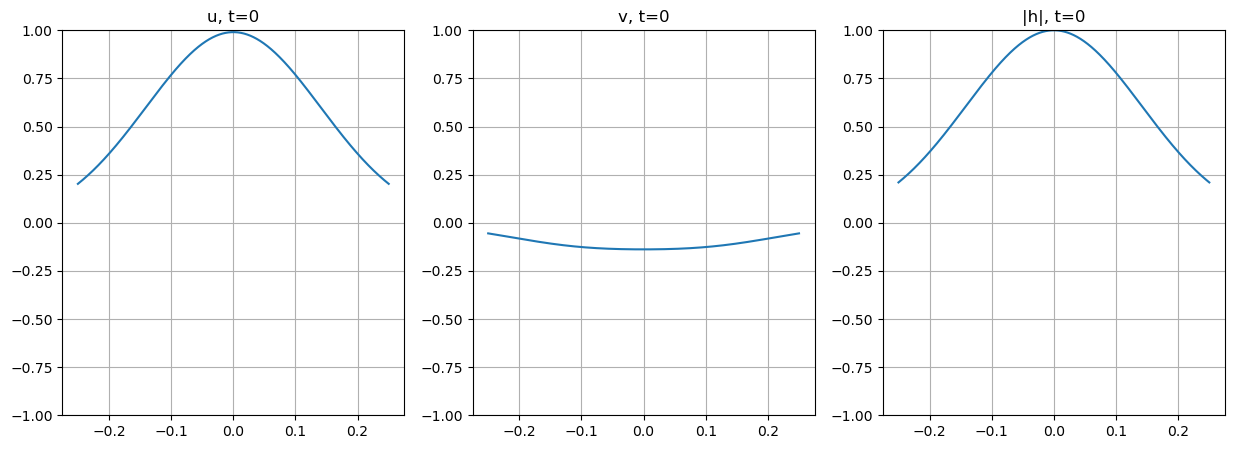

In [5]:
u0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))
v0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))

u0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))
v0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))

du0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 1:2]
dv0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 1:2]

du0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 0:1]
dv0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 0:1]

du0_dxx_fn = lambda xt: jax.vmap(jax.hessian(u0_fn_), in_axes = 0)(xt)[:, 0, 0:1]
dv0_dxx_fn = lambda xt: jax.vmap(jax.hessian(v0_fn_), in_axes = 0)(xt)[:, 0, 0:1]

x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 1000
# x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
x_i = jnp.linspace(*domain[:, 0], n_i).reshape((-1, 1))
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)
du_dxx_i = du0_dxx_fn(jnp.hstack([x_i, t_i]))
dv_dxx_i = dv0_dxx_fn(jnp.hstack([x_i, t_i]))
du_dt_i = 1.0/epsilon*(V*v_i - 1/2*epsilon**2*dv_dxx_i)
dv_dt_i = 1.0/epsilon*(1/2*epsilon**2*du_dxx_i - V*u_i)
du_dx_i = du0_dx_fn(jnp.hstack([x_i, t_i]))
dv_dx_i = dv0_dx_fn(jnp.hstack([x_i, t_i]))

n_cx = 1000
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_Neumann = namedtuple("dataset_Neumann", ["x", "t", "du_dt", "dv_dt", "du_dx", "dv_dx", "du_dxx", "dv_dxx"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
collocation = dataset_Collocation(jnp.vstack([dirichlet.x]),
								 jnp.vstack([dirichlet.t]))
neumann = dataset_Neumann(x_i, t_i, du_dt_i, dv_dt_i, du_dx_i, dv_dx_i, du_dxx_i, dv_dxx_i)

class Time_Marching_Generator:
	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every):
		self.key = key
		self.spatial_points = spatial_points
		self.domain = temporal_domain
		self.batch_size = batch_size
		self.iterations = iterations
		self._count1 = 0
		self._count2 = update_every
		self.update_every = update_every
		
	def _update(self, key, tmax):
		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self._count2 == self.update_every:
			self._count1 = max(self.iterations, self._count1 + 1)
			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
			self.key, subkey = random.split(self.key)
			self._update(subkey, tmax)
			self._count2 = 0
		else:
			self._count2 += 1
		return self.spatial_points, self._t

In [6]:
# pre-train, no bc

lr = 1e-3
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 100, "collocation": 0, "neumann": 100}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Neumann = Batch_Generator(subkeys[1], neumann, batch_size["neumann"])
# Collocation = Time_Marching_Generator(subkeys[3], x_c, [0.0, 0.0], n_cx, iterations, 1)

start_iteration = 0
iterations = 50000
print_every = 200
save_every = 10000
weights = {"c": 0.0, "d": 1.0, "nt": 1.0, "nx": 1.0, "nxx": 1.0, "bcd": 0.0, "bcn": 0.0, "l1": 1e-6, "l2": 1e-6}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
# 		"neumann": dataset_Neumann(*[jnp.vstack([x_, y_]) for x_, y_ in zip(next(Neumann), neumann_b)]),
		"neumann": dataset_Neumann(*next(Neumann)),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"collocation": dataset_Collocation(None, None),
		"bc": dataset_BC(None, None, None),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "nt", "nx", "nxx", "bcd", "bcn", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"neumann": dataset_Neumann(*Neumann.dataset),
			"collocation": dataset_Collocation(*Dirichlet.dataset[:2]),
			"bc": dataset_BC(None, None, None),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/18, 22:52:04, Iteration: 0, Train Loss: 1.1717e+03, c: 3.7677e+01, d: 6.6082e-01, nt: 3.4760e+02, nx: 1.9747e+01, nxx: 8.0375e+02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 2.9638e+02, l2_reg: 1.4085e+02
2020/08/18, 22:52:06, Iteration: 200, Train Loss: 1.9541e+02, c: 2.3409e+02, d: 4.2794e-01, nt: 1.7302e+02, nx: 9.6704e-01, nxx: 2.0996e+01, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.2305e+02, l2_reg: 1.6982e+02
2020/08/18, 22:52:09, Iteration: 400, Train Loss: 2.3000e+01, c: 2.2096e+00, d: 7.0349e-04, nt: 9.9755e+00, nx: 2.2166e-02, nxx: 1.3002e+01, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.4659e+02, l2_reg: 2.0175e+02
2020/08/18, 22:52:11, Iteration: 600, Train Loss: 1.2315e+01, c: 1.1712e+01, d: 8.1978e-02, nt: 7.9638e+00, nx: 1.3338e-02, nxx: 4.2555e+00, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.4945e+02, l2_reg: 2.0504e+02
2020/08/18, 22:52:14, Iteration: 800, Train Loss: 5.9403e+00, c: 9.0164e+00, d: 3.2748e-02, nt: 5.5771e+00, nx: 3.6147e-03, nxx: 3.2684e-01, bcd: 

2020/08/18, 22:53:41, Iteration: 7800, Train Loss: 1.4484e-01, c: 4.9688e-02, d: 2.6412e-05, nt: 5.7893e-02, nx: 7.2549e-04, nxx: 8.6192e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6236e+02, l2_reg: 2.2044e+02
2020/08/18, 22:53:43, Iteration: 8000, Train Loss: 1.4601e-01, c: 4.6079e-02, d: 1.1619e-05, nt: 5.7560e-02, nx: 4.7818e-04, nxx: 8.7961e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6246e+02, l2_reg: 2.2053e+02
2020/08/18, 22:53:46, Iteration: 8200, Train Loss: 1.1302e-01, c: 3.7420e-02, d: 7.6029e-06, nt: 5.6952e-02, nx: 4.4829e-04, nxx: 5.5609e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6254e+02, l2_reg: 2.2057e+02
2020/08/18, 22:53:48, Iteration: 8400, Train Loss: 1.3215e-01, c: 4.3598e-02, d: 2.9479e-06, nt: 5.7492e-02, nx: 2.3728e-04, nxx: 7.4418e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6265e+02, l2_reg: 2.2063e+02
2020/08/18, 22:53:51, Iteration: 8600, Train Loss: 1.1009e-01, c: 3.6999e-02, d: 1.5815e-06, nt: 5.6070e-02, nx: 1.1157e-04, nxx: 5.3903e-02

2020/08/18, 22:55:14, Iteration: 15400, Train Loss: 5.2697e-02, c: 4.5224e-02, d: 6.2799e-06, nt: 4.2011e-02, nx: 9.4133e-05, nxx: 1.0586e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6517e+02, l2_reg: 2.2448e+02
2020/08/18, 22:55:17, Iteration: 15600, Train Loss: 7.8107e-02, c: 5.1634e-02, d: 6.1186e-06, nt: 4.2145e-02, nx: 4.3086e-04, nxx: 3.5526e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6518e+02, l2_reg: 2.2461e+02
2020/08/18, 22:55:19, Iteration: 15800, Train Loss: 4.9608e-02, c: 4.4830e-02, d: 1.7772e-06, nt: 4.2275e-02, nx: 4.4655e-05, nxx: 7.2867e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6525e+02, l2_reg: 2.2479e+02
2020/08/18, 22:55:22, Iteration: 16000, Train Loss: 9.3886e-02, c: 6.3988e-02, d: 2.3628e-05, nt: 4.1731e-02, nx: 5.4579e-04, nxx: 5.1585e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6532e+02, l2_reg: 2.2496e+02
2020/08/18, 22:55:24, Iteration: 16200, Train Loss: 5.8529e-02, c: 4.5880e-02, d: 1.7398e-06, nt: 4.0702e-02, nx: 9.1054e-05, nxx: 1.773

2020/08/18, 22:56:47, Iteration: 23000, Train Loss: 3.7642e-02, c: 3.4749e-02, d: 2.6446e-06, nt: 3.1356e-02, nx: 1.1350e-04, nxx: 6.1696e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6676e+02, l2_reg: 2.3064e+02
2020/08/18, 22:56:50, Iteration: 23200, Train Loss: 1.4093e-01, c: 6.4534e-02, d: 4.9020e-06, nt: 3.0772e-02, nx: 6.0233e-04, nxx: 1.0955e-01, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6681e+02, l2_reg: 2.3083e+02
2020/08/18, 22:56:52, Iteration: 23400, Train Loss: 4.6311e-02, c: 3.8117e-02, d: 2.2497e-06, nt: 3.1792e-02, nx: 7.9759e-05, nxx: 1.4437e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6682e+02, l2_reg: 2.3100e+02
2020/08/18, 22:56:55, Iteration: 23600, Train Loss: 2.6133e-01, c: 1.1623e-01, d: 3.7502e-05, nt: 3.1196e-02, nx: 1.8329e-03, nxx: 2.2826e-01, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6687e+02, l2_reg: 2.3122e+02
2020/08/18, 22:56:57, Iteration: 23800, Train Loss: 3.9264e-02, c: 3.4959e-02, d: 2.9905e-06, nt: 3.0714e-02, nx: 6.9256e-05, nxx: 8.478

2020/08/18, 22:58:21, Iteration: 30600, Train Loss: 4.3291e-02, c: 3.0181e-02, d: 1.8495e-06, nt: 2.2590e-02, nx: 1.2579e-04, nxx: 2.0573e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6892e+02, l2_reg: 2.4016e+02
2020/08/18, 22:58:24, Iteration: 30800, Train Loss: 3.9636e-02, c: 2.8892e-02, d: 1.7107e-06, nt: 2.4129e-02, nx: 1.0200e-04, nxx: 1.5404e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6898e+02, l2_reg: 2.4037e+02
2020/08/18, 22:58:26, Iteration: 31000, Train Loss: 1.7113e-01, c: 7.5736e-02, d: 4.1547e-05, nt: 2.2303e-02, nx: 9.5907e-04, nxx: 1.4783e-01, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6902e+02, l2_reg: 2.4068e+02
2020/08/18, 22:58:29, Iteration: 31200, Train Loss: 2.5651e-02, c: 2.3544e-02, d: 7.0375e-07, nt: 2.2104e-02, nx: 1.8481e-05, nxx: 3.5269e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.6909e+02, l2_reg: 2.4102e+02
2020/08/18, 22:58:31, Iteration: 31400, Train Loss: 3.2094e-02, c: 2.5778e-02, d: 1.7854e-06, nt: 2.2130e-02, nx: 8.2996e-05, nxx: 9.878

2020/08/18, 22:59:55, Iteration: 38200, Train Loss: 1.8578e-02, c: 1.6851e-02, d: 3.2989e-07, nt: 1.6749e-02, nx: 4.8284e-06, nxx: 1.8235e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7143e+02, l2_reg: 2.5214e+02
2020/08/18, 22:59:58, Iteration: 38400, Train Loss: 3.0418e-02, c: 2.2055e-02, d: 3.3459e-06, nt: 1.6865e-02, nx: 1.0372e-04, nxx: 1.3446e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7151e+02, l2_reg: 2.5245e+02
2020/08/18, 23:00:00, Iteration: 38600, Train Loss: 2.1423e-02, c: 1.8058e-02, d: 1.1199e-06, nt: 1.6496e-02, nx: 2.4004e-05, nxx: 4.9015e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7159e+02, l2_reg: 2.5275e+02
2020/08/18, 23:00:03, Iteration: 38800, Train Loss: 1.8578e-01, c: 6.7296e-02, d: 7.3961e-06, nt: 1.6304e-02, nx: 7.4109e-04, nxx: 1.6873e-01, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7167e+02, l2_reg: 2.5306e+02
2020/08/18, 23:00:05, Iteration: 39000, Train Loss: 2.4658e-02, c: 1.9158e-02, d: 2.1069e-06, nt: 1.6161e-02, nx: 7.1016e-05, nxx: 8.424

2020/08/18, 23:01:29, Iteration: 45800, Train Loss: 6.1882e-02, c: 3.0676e-02, d: 2.4368e-05, nt: 1.2149e-02, nx: 3.7506e-04, nxx: 4.9333e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7422e+02, l2_reg: 2.6421e+02
2020/08/18, 23:01:32, Iteration: 46000, Train Loss: 1.8616e-02, c: 1.5867e-02, d: 1.2253e-06, nt: 1.3660e-02, nx: 4.3764e-05, nxx: 4.9115e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7430e+02, l2_reg: 2.6451e+02
2020/08/18, 23:01:34, Iteration: 46200, Train Loss: 1.6944e-02, c: 1.3127e-02, d: 4.7057e-07, nt: 1.1870e-02, nx: 3.0174e-05, nxx: 5.0437e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7437e+02, l2_reg: 2.6476e+02
2020/08/18, 23:01:37, Iteration: 46400, Train Loss: 4.0804e-02, c: 2.0162e-02, d: 7.7053e-07, nt: 1.2048e-02, nx: 8.5236e-05, nxx: 2.8671e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7444e+02, l2_reg: 2.6508e+02
2020/08/18, 23:01:39, Iteration: 46600, Train Loss: 8.2480e-02, c: 3.3383e-02, d: 5.1748e-06, nt: 1.1782e-02, nx: 3.9894e-04, nxx: 7.029

In [7]:
start_iteration += iterations
iterations = 150000
print_every = 200
save_every = 10000
weights = {"c": 0.0, "d": 1.0, "nt": 1.0, "nx": 1.0, "nxx": 1.0, "bcd": 0.0, "bcn": 0.0, "l1": 1e-6, "l2": 1e-6}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
# 		"neumann": dataset_Neumann(*[jnp.vstack([x_, y_]) for x_, y_ in zip(next(Neumann), neumann_b)]),
		"neumann": dataset_Neumann(*next(Neumann)),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"collocation": dataset_Collocation(None, None),
		"bc": dataset_BC(None, None, None),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "nt", "nx", "nxx", "bcd", "bcn", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"neumann": dataset_Neumann(*Neumann.dataset),
			"collocation": dataset_Collocation(*Dirichlet.dataset[:2]),
			"bc": dataset_BC(None, None, None),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/18, 23:04:41, Iteration: 50000, Train Loss: 1.4554e-02, c: 1.1490e-02, d: 8.2476e-07, nt: 1.0290e-02, nx: 3.4613e-05, nxx: 4.2288e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7554e+02, l2_reg: 2.7012e+02
2020/08/18, 23:04:44, Iteration: 50200, Train Loss: 1.2587e-02, c: 1.0395e-02, d: 4.8105e-07, nt: 1.0352e-02, nx: 9.0934e-06, nxx: 2.2256e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7556e+02, l2_reg: 2.7061e+02
2020/08/18, 23:04:46, Iteration: 50400, Train Loss: 1.3680e-02, c: 1.1031e-02, d: 4.0766e-07, nt: 1.1592e-02, nx: 8.7513e-06, nxx: 2.0790e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7565e+02, l2_reg: 2.7085e+02
2020/08/18, 23:04:49, Iteration: 50600, Train Loss: 1.5925e-02, c: 1.3730e-02, d: 8.3831e-07, nt: 1.3259e-02, nx: 9.7853e-06, nxx: 2.6555e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7571e+02, l2_reg: 2.7109e+02
2020/08/18, 23:04:51, Iteration: 50800, Train Loss: 1.3595e-02, c: 1.0981e-02, d: 6.4101e-07, nt: 1.0131e-02, nx: 3.2818e-05, nxx: 3.430

2020/08/18, 23:06:15, Iteration: 57600, Train Loss: 1.6417e-02, c: 1.0958e-02, d: 2.0870e-06, nt: 8.1423e-03, nx: 9.1159e-05, nxx: 8.1811e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7748e+02, l2_reg: 2.8028e+02
2020/08/18, 23:06:17, Iteration: 57800, Train Loss: 1.1269e-01, c: 3.6996e-02, d: 2.3748e-06, nt: 9.2068e-03, nx: 4.2157e-04, nxx: 1.0306e-01, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7751e+02, l2_reg: 2.8053e+02
2020/08/18, 23:06:20, Iteration: 58000, Train Loss: 2.2379e-02, c: 1.1543e-02, d: 1.7100e-06, nt: 8.2699e-03, nx: 6.9597e-05, nxx: 1.4038e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7758e+02, l2_reg: 2.8080e+02
2020/08/18, 23:06:22, Iteration: 58200, Train Loss: 3.4496e-02, c: 1.8643e-02, d: 1.1108e-05, nt: 8.3781e-03, nx: 1.3184e-04, nxx: 2.5975e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7762e+02, l2_reg: 2.8103e+02
2020/08/18, 23:06:25, Iteration: 58400, Train Loss: 1.0440e-02, c: 9.3715e-03, d: 3.3966e-06, nt: 8.0808e-03, nx: 5.7210e-05, nxx: 2.299

2020/08/18, 23:07:48, Iteration: 65200, Train Loss: 2.2912e-02, c: 1.2290e-02, d: 4.1939e-06, nt: 6.4948e-03, nx: 1.7026e-04, nxx: 1.6242e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7913e+02, l2_reg: 2.8978e+02
2020/08/18, 23:07:50, Iteration: 65400, Train Loss: 3.5724e-01, c: 1.2019e-01, d: 4.1542e-05, nt: 6.9085e-03, nx: 2.6629e-03, nxx: 3.4762e-01, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7915e+02, l2_reg: 2.9010e+02
2020/08/18, 23:07:53, Iteration: 65600, Train Loss: 9.4729e-03, c: 7.3929e-03, d: 8.6638e-07, nt: 6.5595e-03, nx: 3.0066e-05, nxx: 2.8824e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7918e+02, l2_reg: 2.9038e+02
2020/08/18, 23:07:55, Iteration: 65800, Train Loss: 9.3601e-03, c: 6.5244e-03, d: 2.1792e-07, nt: 6.4344e-03, nx: 2.2170e-05, nxx: 2.9032e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7923e+02, l2_reg: 2.9058e+02
2020/08/18, 23:07:58, Iteration: 66000, Train Loss: 2.3695e-02, c: 1.2680e-02, d: 5.6987e-06, nt: 6.3682e-03, nx: 2.2437e-04, nxx: 1.709

2020/08/18, 23:09:22, Iteration: 72800, Train Loss: 1.3135e-02, c: 7.2399e-03, d: 5.0852e-07, nt: 5.3550e-03, nx: 4.1252e-05, nxx: 7.7383e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8072e+02, l2_reg: 2.9948e+02
2020/08/18, 23:09:24, Iteration: 73000, Train Loss: 2.1986e-02, c: 9.7910e-03, d: 1.7056e-06, nt: 5.1382e-03, nx: 1.1769e-04, nxx: 1.6729e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8077e+02, l2_reg: 2.9971e+02
2020/08/18, 23:09:27, Iteration: 73200, Train Loss: 2.0373e-02, c: 9.9019e-03, d: 1.4873e-06, nt: 5.0595e-03, nx: 9.5846e-05, nxx: 1.5217e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8082e+02, l2_reg: 2.9999e+02
2020/08/18, 23:09:29, Iteration: 73400, Train Loss: 2.1185e-02, c: 1.1434e-02, d: 4.7933e-06, nt: 5.2149e-03, nx: 1.4167e-04, nxx: 1.5824e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8086e+02, l2_reg: 3.0019e+02
2020/08/18, 23:09:32, Iteration: 73600, Train Loss: 7.1468e-03, c: 5.3640e-03, d: 7.9265e-07, nt: 5.1879e-03, nx: 1.9380e-05, nxx: 1.938

2020/08/18, 23:10:57, Iteration: 80400, Train Loss: 9.0357e-03, c: 4.5194e-03, d: 5.7275e-07, nt: 4.3161e-03, nx: 3.0500e-05, nxx: 4.6886e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8215e+02, l2_reg: 3.0948e+02
2020/08/18, 23:10:59, Iteration: 80600, Train Loss: 6.6811e-03, c: 4.2562e-03, d: 2.4366e-07, nt: 4.7949e-03, nx: 9.6877e-06, nxx: 1.8764e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8222e+02, l2_reg: 3.0973e+02
2020/08/18, 23:11:02, Iteration: 80800, Train Loss: 9.1852e-03, c: 4.7764e-03, d: 3.2790e-07, nt: 4.2772e-03, nx: 2.7884e-05, nxx: 4.8798e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8227e+02, l2_reg: 3.0991e+02
2020/08/18, 23:11:04, Iteration: 81000, Train Loss: 1.0435e-02, c: 5.6347e-03, d: 3.3550e-06, nt: 4.1227e-03, nx: 4.5447e-05, nxx: 6.2633e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8232e+02, l2_reg: 3.1013e+02
2020/08/18, 23:11:07, Iteration: 81200, Train Loss: 6.4967e-03, c: 4.0281e-03, d: 2.4064e-07, nt: 4.0868e-03, nx: 1.4522e-05, nxx: 2.395

2020/08/18, 23:12:31, Iteration: 88000, Train Loss: 1.5779e-01, c: 7.2838e-02, d: 4.8297e-05, nt: 4.4788e-03, nx: 2.1034e-03, nxx: 1.5116e-01, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8355e+02, l2_reg: 3.1916e+02
2020/08/18, 23:12:34, Iteration: 88200, Train Loss: 1.9395e-02, c: 7.8713e-03, d: 1.8714e-06, nt: 3.4923e-03, nx: 7.3598e-05, nxx: 1.5827e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8359e+02, l2_reg: 3.1942e+02
2020/08/18, 23:12:36, Iteration: 88400, Train Loss: 1.4456e-02, c: 5.7294e-03, d: 7.6218e-07, nt: 3.4499e-03, nx: 7.9808e-05, nxx: 1.0925e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8361e+02, l2_reg: 3.1967e+02
2020/08/18, 23:12:39, Iteration: 88600, Train Loss: 1.0063e-02, c: 4.8753e-03, d: 1.2617e-06, nt: 3.4457e-03, nx: 3.7865e-05, nxx: 6.5781e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8363e+02, l2_reg: 3.2014e+02
2020/08/18, 23:12:41, Iteration: 88800, Train Loss: 9.6189e-03, c: 6.5569e-03, d: 1.0739e-06, nt: 4.4538e-03, nx: 4.4066e-05, nxx: 5.120

2020/08/18, 23:14:05, Iteration: 95600, Train Loss: 3.1204e-02, c: 1.2533e-02, d: 5.4257e-06, nt: 2.8018e-03, nx: 2.4876e-04, nxx: 2.8148e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8486e+02, l2_reg: 3.2870e+02
2020/08/18, 23:14:08, Iteration: 95800, Train Loss: 1.2427e-02, c: 5.4714e-03, d: 3.7167e-06, nt: 2.8116e-03, nx: 6.9623e-05, nxx: 9.5424e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8489e+02, l2_reg: 3.2890e+02
2020/08/18, 23:14:10, Iteration: 96000, Train Loss: 7.8365e-03, c: 4.4101e-03, d: 2.5906e-06, nt: 2.8081e-03, nx: 6.6674e-05, nxx: 4.9591e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8493e+02, l2_reg: 3.2913e+02
2020/08/18, 23:14:13, Iteration: 96200, Train Loss: 1.1943e-02, c: 4.9156e-03, d: 1.7467e-06, nt: 2.7578e-03, nx: 8.8609e-05, nxx: 9.0947e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8495e+02, l2_reg: 3.2944e+02
2020/08/18, 23:14:15, Iteration: 96400, Train Loss: 1.3740e-02, c: 5.5319e-03, d: 8.3066e-07, nt: 2.9129e-03, nx: 5.2254e-05, nxx: 1.077

2020/08/18, 23:15:39, Iteration: 103200, Train Loss: 3.6797e-02, c: 1.3094e-02, d: 5.1847e-06, nt: 2.6351e-03, nx: 2.5008e-04, nxx: 3.3906e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8592e+02, l2_reg: 3.3726e+02
2020/08/18, 23:15:42, Iteration: 103400, Train Loss: 2.6428e-02, c: 1.0464e-02, d: 6.5590e-06, nt: 2.3542e-03, nx: 1.8532e-04, nxx: 2.3882e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8594e+02, l2_reg: 3.3750e+02
2020/08/18, 23:15:44, Iteration: 103600, Train Loss: 7.2314e-03, c: 3.6665e-03, d: 1.8133e-06, nt: 2.5613e-03, nx: 5.2860e-05, nxx: 4.6154e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8597e+02, l2_reg: 3.3770e+02
2020/08/18, 23:15:47, Iteration: 103800, Train Loss: 2.9587e-02, c: 1.1929e-02, d: 6.7474e-06, nt: 2.5775e-03, nx: 3.1354e-04, nxx: 2.6689e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8598e+02, l2_reg: 3.3809e+02
2020/08/18, 23:15:49, Iteration: 104000, Train Loss: 6.0550e-03, c: 2.5767e-03, d: 2.2557e-06, nt: 2.2763e-03, nx: 3.9846e-05, nxx: 

2020/08/18, 23:17:13, Iteration: 110800, Train Loss: 2.4434e-02, c: 1.0823e-02, d: 1.9380e-05, nt: 2.6147e-03, nx: 4.3693e-04, nxx: 2.1363e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8677e+02, l2_reg: 3.4571e+02
2020/08/18, 23:17:15, Iteration: 111000, Train Loss: 1.1642e-02, c: 5.0003e-03, d: 1.9593e-06, nt: 2.2686e-03, nx: 9.5021e-05, nxx: 9.2769e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8680e+02, l2_reg: 3.4593e+02
2020/08/18, 23:17:18, Iteration: 111200, Train Loss: 8.8140e-03, c: 3.3493e-03, d: 4.0213e-07, nt: 2.0310e-03, nx: 3.7605e-05, nxx: 6.7450e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8681e+02, l2_reg: 3.4607e+02
2020/08/18, 23:17:20, Iteration: 111400, Train Loss: 4.5135e-02, c: 1.4318e-02, d: 1.2119e-05, nt: 2.8379e-03, nx: 2.9707e-04, nxx: 4.1988e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8683e+02, l2_reg: 3.4657e+02
2020/08/18, 23:17:23, Iteration: 111600, Train Loss: 4.9382e-03, c: 2.0903e-03, d: 1.3669e-06, nt: 2.0523e-03, nx: 5.0024e-05, nxx: 

2020/08/18, 23:18:47, Iteration: 118400, Train Loss: 4.2153e-02, c: 1.7134e-02, d: 1.4491e-05, nt: 2.2314e-03, nx: 3.4923e-04, nxx: 3.9558e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8732e+02, l2_reg: 3.5360e+02
2020/08/18, 23:18:49, Iteration: 118600, Train Loss: 6.4250e-03, c: 2.5588e-03, d: 1.0105e-06, nt: 1.6882e-03, nx: 2.5617e-05, nxx: 4.7102e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8732e+02, l2_reg: 3.5376e+02
2020/08/18, 23:18:51, Iteration: 118800, Train Loss: 4.7789e-02, c: 1.5076e-02, d: 4.7764e-06, nt: 1.8316e-03, nx: 3.1070e-04, nxx: 4.5642e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8733e+02, l2_reg: 3.5400e+02
2020/08/18, 23:18:54, Iteration: 119000, Train Loss: 6.5674e-03, c: 2.8545e-03, d: 1.2450e-06, nt: 1.6651e-03, nx: 4.3639e-05, nxx: 4.8574e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8733e+02, l2_reg: 3.5415e+02
2020/08/18, 23:18:56, Iteration: 119200, Train Loss: 6.6509e-03, c: 2.6160e-03, d: 1.8779e-06, nt: 3.2759e-03, nx: 3.3443e-05, nxx: 

2020/08/18, 23:20:20, Iteration: 126000, Train Loss: 3.1750e-03, c: 1.1652e-03, d: 9.0154e-08, nt: 1.5661e-03, nx: 4.7506e-06, nxx: 1.6041e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8681e+02, l2_reg: 3.6048e+02
2020/08/18, 23:20:23, Iteration: 126200, Train Loss: 3.3749e-03, c: 1.7853e-03, d: 1.8874e-06, nt: 1.6152e-03, nx: 9.6764e-06, nxx: 1.7481e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8673e+02, l2_reg: 3.6058e+02
2020/08/18, 23:20:25, Iteration: 126400, Train Loss: 6.8973e-03, c: 2.3207e-03, d: 2.3715e-06, nt: 2.7118e-03, nx: 2.2030e-05, nxx: 4.1611e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8666e+02, l2_reg: 3.6067e+02
2020/08/18, 23:20:28, Iteration: 126600, Train Loss: 6.0498e-03, c: 2.3178e-03, d: 1.3683e-06, nt: 2.0419e-03, nx: 3.1716e-05, nxx: 3.9748e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.8658e+02, l2_reg: 3.6075e+02
2020/08/18, 23:20:30, Iteration: 126800, Train Loss: 9.2139e-03, c: 3.8505e-03, d: 2.8620e-06, nt: 2.6104e-03, nx: 8.5292e-05, nxx: 

2020/08/18, 23:23:57, Iteration: 143600, Train Loss: 7.3538e-03, c: 3.2058e-03, d: 1.9195e-06, nt: 1.3889e-03, nx: 5.1540e-05, nxx: 5.9115e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7679e+02, l2_reg: 3.7349e+02
2020/08/18, 23:24:00, Iteration: 143800, Train Loss: 8.4036e-03, c: 2.6444e-03, d: 8.0403e-07, nt: 1.3348e-03, nx: 3.8639e-05, nxx: 7.0293e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7675e+02, l2_reg: 3.7365e+02
2020/08/18, 23:24:02, Iteration: 144000, Train Loss: 4.8735e-02, c: 2.7086e-02, d: 3.5069e-05, nt: 1.5288e-03, nx: 5.8981e-04, nxx: 4.6581e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7666e+02, l2_reg: 3.7378e+02
2020/08/18, 23:24:05, Iteration: 144200, Train Loss: 5.0417e-03, c: 1.5039e-03, d: 4.6982e-07, nt: 1.3109e-03, nx: 1.4395e-05, nxx: 3.7160e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7655e+02, l2_reg: 3.7392e+02
2020/08/18, 23:24:07, Iteration: 144400, Train Loss: 4.6094e-03, c: 1.2695e-03, d: 2.4551e-07, nt: 1.3946e-03, nx: 1.1106e-05, nxx: 

2020/08/18, 23:25:31, Iteration: 151200, Train Loss: 1.9196e-02, c: 5.9518e-03, d: 2.0400e-06, nt: 1.2373e-03, nx: 1.1531e-04, nxx: 1.7842e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7424e+02, l2_reg: 3.7993e+02
2020/08/18, 23:25:34, Iteration: 151400, Train Loss: 7.5289e-03, c: 2.2681e-03, d: 1.3765e-06, nt: 1.2021e-03, nx: 8.5540e-05, nxx: 6.2399e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7418e+02, l2_reg: 3.8001e+02
2020/08/18, 23:25:36, Iteration: 151600, Train Loss: 6.4669e-03, c: 2.0667e-03, d: 1.3149e-06, nt: 1.9384e-03, nx: 2.9008e-05, nxx: 4.4981e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7421e+02, l2_reg: 3.8042e+02
2020/08/18, 23:25:39, Iteration: 151800, Train Loss: 5.7339e-03, c: 1.9832e-03, d: 1.1620e-06, nt: 1.2857e-03, nx: 2.4297e-05, nxx: 4.4227e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7413e+02, l2_reg: 3.8050e+02
2020/08/18, 23:25:41, Iteration: 152000, Train Loss: 1.6660e-02, c: 7.3630e-03, d: 5.7800e-06, nt: 1.1794e-03, nx: 2.3559e-04, nxx: 

2020/08/18, 23:27:06, Iteration: 158800, Train Loss: 6.5549e-03, c: 2.2608e-03, d: 1.1797e-06, nt: 1.1505e-03, nx: 6.0268e-05, nxx: 5.3430e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7379e+02, l2_reg: 3.8626e+02
2020/08/18, 23:27:08, Iteration: 159000, Train Loss: 3.9509e-03, c: 1.2518e-03, d: 6.1790e-07, nt: 1.1026e-03, nx: 1.5865e-05, nxx: 2.8318e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7378e+02, l2_reg: 3.8634e+02
2020/08/18, 23:27:11, Iteration: 159200, Train Loss: 9.4706e-02, c: 3.5348e-02, d: 3.8850e-05, nt: 1.3538e-03, nx: 6.9007e-04, nxx: 9.2623e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7416e+02, l2_reg: 3.8680e+02
2020/08/18, 23:27:13, Iteration: 159400, Train Loss: 2.2268e-03, c: 5.4580e-04, d: 9.9756e-08, nt: 1.0977e-03, nx: 2.0220e-06, nxx: 1.1269e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7392e+02, l2_reg: 3.8700e+02
2020/08/18, 23:27:15, Iteration: 159600, Train Loss: 1.3264e-02, c: 4.6179e-03, d: 1.3193e-06, nt: 1.2462e-03, nx: 5.1303e-05, nxx: 

2020/08/18, 23:28:39, Iteration: 166400, Train Loss: 6.4252e-03, c: 2.2282e-03, d: 1.3709e-06, nt: 1.2032e-03, nx: 5.4297e-05, nxx: 5.1664e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7409e+02, l2_reg: 3.9273e+02
2020/08/18, 23:28:41, Iteration: 166600, Train Loss: 6.3330e-03, c: 1.9928e-03, d: 9.8082e-08, nt: 1.2678e-03, nx: 2.8926e-05, nxx: 5.0362e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7410e+02, l2_reg: 3.9282e+02
2020/08/18, 23:28:44, Iteration: 166800, Train Loss: 4.6689e-02, c: 1.9758e-02, d: 1.4101e-05, nt: 1.4570e-03, nx: 3.3907e-04, nxx: 4.4879e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7409e+02, l2_reg: 3.9295e+02
2020/08/18, 23:28:46, Iteration: 167000, Train Loss: 6.5551e-03, c: 2.1293e-03, d: 1.0748e-06, nt: 1.1205e-03, nx: 3.1977e-05, nxx: 5.4016e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7411e+02, l2_reg: 3.9319e+02
2020/08/18, 23:28:49, Iteration: 167200, Train Loss: 7.6790e-03, c: 4.3668e-03, d: 2.6121e-06, nt: 1.9906e-03, nx: 3.4998e-05, nxx: 

2020/08/18, 23:30:13, Iteration: 174000, Train Loss: 3.9017e-03, c: 1.7174e-03, d: 1.7610e-06, nt: 1.1698e-03, nx: 5.6064e-05, nxx: 2.6741e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7444e+02, l2_reg: 3.9883e+02
2020/08/18, 23:30:16, Iteration: 174200, Train Loss: 3.6990e-03, c: 1.1122e-03, d: 6.0620e-07, nt: 1.0450e-03, nx: 1.7556e-05, nxx: 2.6359e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7445e+02, l2_reg: 3.9891e+02
2020/08/18, 23:30:18, Iteration: 174400, Train Loss: 5.5749e-03, c: 2.2583e-03, d: 5.8514e-07, nt: 1.2975e-03, nx: 1.7977e-05, nxx: 4.2589e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7446e+02, l2_reg: 3.9909e+02
2020/08/18, 23:30:20, Iteration: 174600, Train Loss: 6.3745e-03, c: 2.3179e-03, d: 2.7989e-06, nt: 1.0925e-03, nx: 4.2313e-05, nxx: 5.2369e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7445e+02, l2_reg: 3.9915e+02
2020/08/18, 23:30:23, Iteration: 174800, Train Loss: 8.0431e-03, c: 2.9763e-03, d: 2.7530e-07, nt: 1.6515e-03, nx: 1.9482e-05, nxx: 

2020/08/18, 23:31:47, Iteration: 181600, Train Loss: 6.3107e-03, c: 1.7025e-03, d: 1.6705e-06, nt: 1.1296e-03, nx: 3.4998e-05, nxx: 5.1445e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7498e+02, l2_reg: 4.0496e+02
2020/08/18, 23:31:50, Iteration: 181800, Train Loss: 2.7808e-02, c: 1.0412e-02, d: 5.8456e-06, nt: 1.5636e-03, nx: 2.5977e-04, nxx: 2.5979e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7498e+02, l2_reg: 4.0509e+02
2020/08/18, 23:31:52, Iteration: 182000, Train Loss: 5.5913e-03, c: 1.8735e-03, d: 3.1553e-07, nt: 1.3227e-03, nx: 2.5031e-05, nxx: 4.2433e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7500e+02, l2_reg: 4.0533e+02
2020/08/18, 23:31:55, Iteration: 182200, Train Loss: 5.4689e-03, c: 1.8875e-03, d: 7.4379e-07, nt: 1.1156e-03, nx: 2.6944e-05, nxx: 4.3256e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7502e+02, l2_reg: 4.0549e+02
2020/08/18, 23:31:57, Iteration: 182400, Train Loss: 1.6898e-02, c: 5.0598e-03, d: 1.3265e-06, nt: 1.1178e-03, nx: 8.0572e-05, nxx: 

2020/08/18, 23:33:21, Iteration: 189200, Train Loss: 1.7244e-02, c: 6.1915e-03, d: 1.8215e-06, nt: 1.7141e-03, nx: 9.8339e-05, nxx: 1.5430e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7556e+02, l2_reg: 4.1097e+02
2020/08/18, 23:33:24, Iteration: 189400, Train Loss: 1.2024e-02, c: 3.7692e-03, d: 1.0608e-06, nt: 1.0029e-03, nx: 8.0186e-05, nxx: 1.0940e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7558e+02, l2_reg: 4.1109e+02
2020/08/18, 23:33:26, Iteration: 189600, Train Loss: 9.3365e-03, c: 3.2177e-03, d: 1.1951e-06, nt: 1.0592e-03, nx: 5.1479e-05, nxx: 8.2246e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7558e+02, l2_reg: 4.1122e+02
2020/08/18, 23:33:28, Iteration: 189800, Train Loss: 1.7720e-02, c: 6.0568e-03, d: 6.9582e-06, nt: 1.4076e-03, nx: 2.6062e-04, nxx: 1.6045e-02, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7560e+02, l2_reg: 4.1135e+02
2020/08/18, 23:33:31, Iteration: 190000, Train Loss: 3.9854e-03, c: 1.4871e-03, d: 2.9286e-06, nt: 1.0419e-03, nx: 2.0917e-05, nxx: 

2020/08/18, 23:34:55, Iteration: 196800, Train Loss: 7.6701e-03, c: 3.8080e-03, d: 5.0635e-06, nt: 1.4346e-03, nx: 1.3583e-04, nxx: 6.0947e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7605e+02, l2_reg: 4.1649e+02
2020/08/18, 23:34:58, Iteration: 197000, Train Loss: 4.5969e-03, c: 1.1479e-03, d: 3.6440e-06, nt: 1.4406e-03, nx: 1.7486e-05, nxx: 3.1351e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7606e+02, l2_reg: 4.1663e+02
2020/08/18, 23:35:00, Iteration: 197200, Train Loss: 5.9792e-03, c: 2.6038e-03, d: 1.9621e-06, nt: 1.0794e-03, nx: 1.9571e-05, nxx: 4.8783e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7608e+02, l2_reg: 4.1679e+02
2020/08/18, 23:35:02, Iteration: 197400, Train Loss: 4.8721e-03, c: 1.7100e-03, d: 9.8742e-07, nt: 1.1055e-03, nx: 4.2349e-05, nxx: 3.7233e-03, bcd: 0.0000e+00, bcn: 0.0000e+00, l1_reg: 3.7632e+02, l2_reg: 4.1736e+02
2020/08/18, 23:35:05, Iteration: 197600, Train Loss: 5.8819e-03, c: 1.6152e-03, d: 1.0592e-06, nt: 1.0885e-03, nx: 3.4381e-05, nxx: 

In [10]:
start_iteration += iterations
iterations = 2000000
print_every = 1000
save_every = 10000
weights = {"c": 1e-2, "d": 1.0, "nt": 1.0, "nx": 1.0, "nxx": 1.0, "bcd": 1.0, "bcn": 1.0, "l1": 1e-6, "l2": 1e-6}

key, subkey = random.split(key)
Collocation = Time_Marching_Generator(subkey, x_c, domain[:, 1], n_cx, iterations, 1)

for iteration in range(start_iteration, start_iteration+iterations+1):
	c = next(Collocation)
	d = next(Dirichlet)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"bc": dataset_BC(jnp.ones_like(c[0])*domain[0, 0], jnp.ones_like(c[0])*domain[1, 0], c[1]),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "nt", "nx", "nxx", "bcd", "bcn", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"neumann": dataset_Neumann(*Neumann.dataset),
			"collocation": batch["collocation"],
			"bc": batch["bc"],
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/19, 00:16:04, Iteration: 2200000, Train Loss: 1.6278e+02, c: 3.4314e+03, d: 2.5734e-04, nt: 8.2517e-02, nx: 1.4469e-02, nxx: 3.4908e-01, bcd: 3.9182e+00, bcn: 1.2410e+02, l1_reg: 3.7646e+02, l2_reg: 4.1942e+02
2020/08/19, 00:16:23, Iteration: 2201000, Train Loss: 2.7542e+00, c: 1.5899e+02, d: 2.2679e-03, nt: 1.7920e-01, nx: 1.1111e-03, nxx: 1.4031e-01, bcd: 3.4374e-02, bcn: 8.0703e-01, l1_reg: 4.1850e+02, l2_reg: 4.9477e+02
2020/08/19, 00:16:44, Iteration: 2202000, Train Loss: 1.6940e+00, c: 7.3550e+01, d: 1.2889e-03, nt: 1.8859e-01, nx: 7.6726e-04, nxx: 2.3169e-02, bcd: 2.5754e-02, bcn: 7.1888e-01, l1_reg: 4.2957e+02, l2_reg: 5.2604e+02
2020/08/19, 00:17:03, Iteration: 2203000, Train Loss: 1.3976e+00, c: 4.7360e+01, d: 7.8862e-04, nt: 1.9567e-01, nx: 1.3877e-03, nxx: 1.1405e-01, bcd: 1.5797e-02, bcn: 5.9626e-01, l1_reg: 4.3721e+02, l2_reg: 5.5240e+02
2020/08/19, 00:17:23, Iteration: 2204000, Train Loss: 1.3172e+00, c: 3.4651e+01, d: 6.0613e-04, nt: 1.9229e-01, nx: 4.7288e-04, 

2020/08/19, 00:28:40, Iteration: 2238000, Train Loss: 5.5965e-01, c: 5.3419e+00, d: 9.7629e-05, nt: 5.8055e-02, nx: 1.9443e-04, nxx: 1.5151e-02, bcd: 2.3144e-03, bcn: 4.3041e-01, l1_reg: 5.0798e+02, l2_reg: 1.1105e+03
2020/08/19, 00:29:00, Iteration: 2239000, Train Loss: 5.4156e-01, c: 6.9169e+00, d: 1.6341e-04, nt: 6.3418e-02, nx: 1.9310e-04, nxx: 8.8833e-03, bcd: 2.2338e-03, bcn: 3.9750e-01, l1_reg: 5.0892e+02, l2_reg: 1.1226e+03
2020/08/19, 00:29:19, Iteration: 2240000, Train Loss: 6.3431e-01, c: 5.8362e+00, d: 8.0938e-05, nt: 4.7485e-02, nx: 2.5649e-04, nxx: 2.5080e-02, bcd: 2.1621e-03, bcn: 5.0088e-01, l1_reg: 5.0974e+02, l2_reg: 1.1334e+03
2020/08/19, 00:29:39, Iteration: 2241000, Train Loss: 5.1285e-01, c: 6.2852e+00, d: 6.7122e-05, nt: 5.4285e-02, nx: 1.2388e-04, nxx: 8.5849e-03, bcd: 2.1453e-03, bcn: 3.8479e-01, l1_reg: 5.1053e+02, l2_reg: 1.1435e+03
2020/08/19, 00:29:59, Iteration: 2242000, Train Loss: 6.2416e-01, c: 5.5797e+00, d: 9.8222e-05, nt: 5.5474e-02, nx: 6.5363e-04, 

2020/08/19, 00:41:15, Iteration: 2276000, Train Loss: 5.5990e-01, c: 6.0267e+00, d: 5.5609e-05, nt: 3.4580e-02, nx: 5.1919e-05, nxx: 5.1315e-03, bcd: 1.1071e-03, bcn: 4.5871e-01, l1_reg: 5.3489e+02, l2_reg: 1.5092e+03
2020/08/19, 00:41:34, Iteration: 2277000, Train Loss: 4.0115e-01, c: 4.3030e+00, d: 9.0679e-05, nt: 4.6407e-02, nx: 2.1654e-05, nxx: 4.5739e-03, bcd: 1.0092e-03, bcn: 3.0602e-01, l1_reg: 5.3561e+02, l2_reg: 1.5225e+03
2020/08/19, 00:41:54, Iteration: 2278000, Train Loss: 4.4740e-01, c: 6.0857e+00, d: 5.1788e-05, nt: 3.6507e-02, nx: 1.4226e-04, nxx: 1.0890e-02, bcd: 1.0388e-03, bcn: 3.3791e-01, l1_reg: 5.3627e+02, l2_reg: 1.5354e+03
2020/08/19, 00:42:15, Iteration: 2279000, Train Loss: 4.5683e-01, c: 5.5280e+00, d: 6.6064e-05, nt: 3.3332e-02, nx: 1.0901e-04, nxx: 6.8535e-03, bcd: 9.6512e-04, bcn: 3.6022e-01, l1_reg: 5.3690e+02, l2_reg: 1.5468e+03
2020/08/19, 00:42:34, Iteration: 2280000, Train Loss: 6.4815e-01, c: 5.8533e+00, d: 1.2243e-05, nt: 4.3501e-02, nx: 9.5692e-05, 

2020/08/19, 00:53:51, Iteration: 2314000, Train Loss: 3.1488e-01, c: 5.4731e+00, d: 5.9914e-05, nt: 2.7626e-02, nx: 2.8666e-05, nxx: 3.9713e-03, bcd: 7.4387e-04, bcn: 2.2772e-01, l1_reg: 5.5639e+02, l2_reg: 1.8542e+03
2020/08/19, 00:54:11, Iteration: 2315000, Train Loss: 5.1839e-01, c: 7.0283e+00, d: 6.1588e-05, nt: 2.1660e-02, nx: 2.0449e-04, nxx: 3.1945e-02, bcd: 7.0381e-04, bcn: 3.9353e-01, l1_reg: 5.5700e+02, l2_reg: 1.8608e+03
2020/08/19, 00:54:31, Iteration: 2316000, Train Loss: 3.9696e-01, c: 6.2018e+00, d: 3.9664e-05, nt: 2.0701e-02, nx: 9.7140e-05, nxx: 6.5228e-03, bcd: 7.1615e-04, bcn: 3.0686e-01, l1_reg: 5.5759e+02, l2_reg: 1.8673e+03
2020/08/19, 00:54:51, Iteration: 2317000, Train Loss: 5.9409e-01, c: 6.5815e+00, d: 2.7248e-05, nt: 2.4773e-02, nx: 1.6859e-04, nxx: 7.0309e-03, bcd: 7.0180e-04, bcn: 4.9558e-01, l1_reg: 5.5818e+02, l2_reg: 1.8741e+03
2020/08/19, 00:55:11, Iteration: 2318000, Train Loss: 2.8555e-01, c: 4.6103e+00, d: 2.2625e-05, nt: 4.0715e-02, nx: 4.6627e-05, 

2020/08/19, 01:06:26, Iteration: 2352000, Train Loss: 3.5964e-01, c: 6.0876e+00, d: 2.5550e-05, nt: 1.9353e-02, nx: 2.4981e-05, nxx: 3.9051e-03, bcd: 6.1211e-04, bcn: 2.7485e-01, l1_reg: 5.7551e+02, l2_reg: 2.0671e+03
2020/08/19, 01:06:46, Iteration: 2353000, Train Loss: 2.8309e-01, c: 3.7625e+00, d: 2.5117e-05, nt: 1.3499e-02, nx: 6.1579e-05, nxx: 9.9192e-03, bcd: 5.3728e-04, bcn: 2.2142e-01, l1_reg: 5.7592e+02, l2_reg: 2.0729e+03
2020/08/19, 01:07:05, Iteration: 2354000, Train Loss: 3.4599e-01, c: 4.6847e+00, d: 2.5824e-05, nt: 3.5134e-02, nx: 1.6115e-04, nxx: 2.0519e-02, bcd: 5.4818e-04, bcn: 2.4276e-01, l1_reg: 5.7632e+02, l2_reg: 2.0783e+03
2020/08/19, 01:07:25, Iteration: 2355000, Train Loss: 2.9551e-01, c: 4.8211e+00, d: 1.9564e-05, nt: 2.0732e-02, nx: 3.8032e-05, nxx: 3.4140e-03, bcd: 6.2404e-04, bcn: 2.2247e-01, l1_reg: 5.7675e+02, l2_reg: 2.0837e+03
2020/08/19, 01:07:45, Iteration: 2356000, Train Loss: 3.0234e-01, c: 5.2729e+00, d: 8.8327e-06, nt: 1.9972e-02, nx: 2.2816e-04, 

2020/08/19, 01:19:01, Iteration: 2390000, Train Loss: 3.7215e-01, c: 6.0640e+00, d: 4.0480e-05, nt: 8.4565e-03, nx: 3.7296e-05, nxx: 3.0267e-03, bcd: 5.2752e-04, bcn: 2.9943e-01, l1_reg: 5.8712e+02, l2_reg: 2.1849e+03
2020/08/19, 01:19:21, Iteration: 2391000, Train Loss: 3.7185e-01, c: 4.8222e+00, d: 3.3736e-05, nt: 8.2149e-03, nx: 4.6347e-04, nxx: 3.2066e-02, bcd: 5.9604e-04, bcn: 2.8226e-01, l1_reg: 5.8743e+02, l2_reg: 2.1879e+03
2020/08/19, 01:19:41, Iteration: 2392000, Train Loss: 5.7406e-01, c: 5.7756e+00, d: 4.0798e-05, nt: 1.3869e-02, nx: 1.7969e-04, nxx: 1.0649e-02, bcd: 5.0821e-04, bcn: 4.9106e-01, l1_reg: 5.8777e+02, l2_reg: 2.1914e+03
2020/08/19, 01:20:00, Iteration: 2393000, Train Loss: 3.5902e-01, c: 4.9107e+00, d: 1.6497e-06, nt: 1.8220e-02, nx: 9.7218e-05, nxx: 6.5838e-03, bcd: 5.0566e-04, bcn: 2.8450e-01, l1_reg: 5.8811e+02, l2_reg: 2.1948e+03
2020/08/19, 01:20:20, Iteration: 2394000, Train Loss: 2.6659e-01, c: 5.2998e+00, d: 8.2344e-06, nt: 1.1953e-02, nx: 1.8504e-04, 

2020/08/19, 01:31:35, Iteration: 2428000, Train Loss: 3.3799e-01, c: 3.3758e+00, d: 5.3586e-06, nt: 7.6231e-03, nx: 4.4774e-05, nxx: 5.9471e-03, bcd: 6.0767e-04, bcn: 2.9000e-01, l1_reg: 6.0271e+02, l2_reg: 2.3769e+03
2020/08/19, 01:31:55, Iteration: 2429000, Train Loss: 2.2998e-01, c: 5.2965e+00, d: 7.4426e-06, nt: 1.8539e-02, nx: 7.7768e-05, nxx: 8.1429e-03, bcd: 6.1809e-04, bcn: 1.4963e-01, l1_reg: 6.0316e+02, l2_reg: 2.3843e+03
2020/08/19, 01:32:15, Iteration: 2430000, Train Loss: 3.5174e-01, c: 4.4343e+00, d: 1.4942e-05, nt: 8.5426e-02, nx: 6.4405e-05, nxx: 1.2926e-02, bcd: 6.1529e-04, bcn: 2.0835e-01, l1_reg: 6.0365e+02, l2_reg: 2.3916e+03
2020/08/19, 01:32:35, Iteration: 2431000, Train Loss: 2.8882e-01, c: 5.5605e+00, d: 3.8980e-06, nt: 1.2735e-02, nx: 2.5437e-05, nxx: 2.4752e-03, bcd: 7.0331e-04, bcn: 2.1727e-01, l1_reg: 6.0407e+02, l2_reg: 2.3975e+03
2020/08/19, 01:32:55, Iteration: 2432000, Train Loss: 2.8087e-01, c: 3.8013e+00, d: 2.1110e-06, nt: 1.2016e-02, nx: 1.4285e-04, 

2020/08/19, 01:44:10, Iteration: 2466000, Train Loss: 4.0617e-01, c: 3.2440e+00, d: 1.1355e-06, nt: 7.4176e-03, nx: 4.2582e-05, nxx: 5.1109e-03, bcd: 8.2030e-04, bcn: 3.6034e-01, l1_reg: 6.1793e+02, l2_reg: 2.6005e+03
2020/08/19, 01:44:30, Iteration: 2467000, Train Loss: 2.7507e-01, c: 4.4445e+00, d: 3.0392e-05, nt: 3.9810e-02, nx: 1.0896e-04, nxx: 7.7912e-03, bcd: 7.3342e-04, bcn: 1.8215e-01, l1_reg: 6.1836e+02, l2_reg: 2.6066e+03
2020/08/19, 01:44:49, Iteration: 2468000, Train Loss: 3.3524e-01, c: 5.0945e+00, d: 3.8997e-06, nt: 7.8624e-03, nx: 5.6222e-05, nxx: 4.9799e-03, bcd: 8.7005e-04, bcn: 2.7052e-01, l1_reg: 6.1873e+02, l2_reg: 2.6119e+03
2020/08/19, 01:45:09, Iteration: 2469000, Train Loss: 2.5221e-01, c: 2.9138e+00, d: 1.2118e-05, nt: 1.9472e-02, nx: 3.0703e-05, nxx: 2.2182e-03, bcd: 5.9864e-04, bcn: 2.0074e-01, l1_reg: 6.1905e+02, l2_reg: 2.6171e+03
2020/08/19, 01:45:29, Iteration: 2470000, Train Loss: 2.7820e-01, c: 5.1954e+00, d: 7.1998e-06, nt: 6.6105e-02, nx: 1.8915e-04, 

2020/08/19, 01:56:43, Iteration: 2504000, Train Loss: 2.9183e-01, c: 5.6607e+00, d: 6.1032e-06, nt: 5.1750e-03, nx: 3.9852e-05, nxx: 5.5449e-03, bcd: 8.2122e-04, bcn: 2.2364e-01, l1_reg: 6.3130e+02, l2_reg: 2.8016e+03
2020/08/19, 01:57:03, Iteration: 2505000, Train Loss: 3.4758e-01, c: 2.6527e+00, d: 1.1544e-05, nt: 1.3333e-02, nx: 1.7029e-04, nxx: 8.2373e-03, bcd: 6.7800e-04, bcn: 2.9863e-01, l1_reg: 6.3159e+02, l2_reg: 2.8063e+03
2020/08/19, 01:57:23, Iteration: 2506000, Train Loss: 2.7008e-01, c: 3.6909e+00, d: 1.0564e-05, nt: 8.0815e-03, nx: 1.2148e-04, nxx: 9.1035e-03, bcd: 7.6724e-04, bcn: 2.1508e-01, l1_reg: 6.3193e+02, l2_reg: 2.8112e+03
2020/08/19, 01:57:43, Iteration: 2507000, Train Loss: 1.9459e-01, c: 4.3718e+00, d: 2.0554e-05, nt: 4.0174e-02, nx: 1.3684e-04, nxx: 1.2796e-02, bcd: 8.0142e-04, bcn: 9.6938e-02, l1_reg: 6.3218e+02, l2_reg: 2.8149e+03
2020/08/19, 01:58:03, Iteration: 2508000, Train Loss: 3.8662e-01, c: 4.8153e+00, d: 5.8999e-05, nt: 2.5955e-02, nx: 2.2815e-04, 

2020/08/19, 02:09:16, Iteration: 2542000, Train Loss: 3.4021e-01, c: 5.0163e+00, d: 2.0158e-06, nt: 9.8488e-03, nx: 4.2465e-05, nxx: 1.5221e-03, bcd: 8.3222e-04, bcn: 2.7780e-01, l1_reg: 6.4135e+02, l2_reg: 2.9239e+03
2020/08/19, 02:09:36, Iteration: 2543000, Train Loss: 2.6679e-01, c: 2.9385e+00, d: 2.5327e-05, nt: 1.7811e-02, nx: 4.2062e-05, nxx: 3.7501e-03, bcd: 6.8249e-04, bcn: 2.1510e-01, l1_reg: 6.4163e+02, l2_reg: 2.9268e+03
2020/08/19, 02:09:55, Iteration: 2544000, Train Loss: 3.4461e-01, c: 3.9246e+00, d: 9.5304e-06, nt: 2.8044e-02, nx: 2.1774e-05, nxx: 3.4879e-03, bcd: 7.6706e-04, bcn: 2.7304e-01, l1_reg: 6.4189e+02, l2_reg: 2.9296e+03
2020/08/19, 02:10:15, Iteration: 2545000, Train Loss: 3.7680e-01, c: 4.3330e+00, d: 1.5427e-05, nt: 3.5595e-03, nx: 7.0772e-05, nxx: 5.8483e-03, bcd: 7.4307e-04, bcn: 3.2323e-01, l1_reg: 6.4219e+02, l2_reg: 2.9325e+03
2020/08/19, 02:10:35, Iteration: 2546000, Train Loss: 1.8692e-01, c: 3.1103e+00, d: 1.7653e-05, nt: 2.8247e-02, nx: 4.7472e-05, 

2020/08/19, 02:21:50, Iteration: 2580000, Train Loss: 2.2382e-01, c: 3.8996e+00, d: 6.5621e-06, nt: 1.5473e-02, nx: 6.4894e-05, nxx: 7.4729e-03, bcd: 6.9948e-04, bcn: 1.6110e-01, l1_reg: 6.4987e+02, l2_reg: 3.0356e+03
2020/08/19, 02:22:10, Iteration: 2581000, Train Loss: 2.6925e-01, c: 3.6821e+00, d: 3.4710e-06, nt: 1.0005e-02, nx: 3.5248e-05, nxx: 3.1407e-03, bcd: 8.3251e-04, bcn: 2.1841e-01, l1_reg: 6.5008e+02, l2_reg: 3.0408e+03
2020/08/19, 02:22:30, Iteration: 2582000, Train Loss: 3.3611e-01, c: 5.1318e+00, d: 1.4533e-05, nt: 4.1510e-03, nx: 5.9796e-05, nxx: 4.4651e-03, bcd: 8.6136e-04, bcn: 2.7524e-01, l1_reg: 6.5023e+02, l2_reg: 3.0454e+03
2020/08/19, 02:22:49, Iteration: 2583000, Train Loss: 1.9237e-01, c: 4.1086e+00, d: 9.5544e-06, nt: 1.3279e-02, nx: 9.2436e-05, nxx: 1.0659e-02, bcd: 6.8671e-04, bcn: 1.2656e-01, l1_reg: 6.5043e+02, l2_reg: 3.0502e+03
2020/08/19, 02:23:09, Iteration: 2584000, Train Loss: 1.8992e-01, c: 3.9352e+00, d: 2.9661e-05, nt: 1.4881e-02, nx: 2.3856e-05, 

2020/08/19, 02:34:21, Iteration: 2618000, Train Loss: 1.7187e-01, c: 3.0744e+00, d: 7.8493e-06, nt: 7.3489e-03, nx: 5.2713e-05, nxx: 4.8498e-03, bcd: 7.6242e-04, bcn: 1.2810e-01, l1_reg: 6.5620e+02, l2_reg: 3.1681e+03
2020/08/19, 02:34:41, Iteration: 2619000, Train Loss: 3.0862e-01, c: 4.0354e+00, d: 9.6305e-06, nt: 6.3962e-03, nx: 3.1754e-05, nxx: 3.0663e-03, bcd: 7.7028e-04, bcn: 2.5799e-01, l1_reg: 6.5633e+02, l2_reg: 3.1701e+03
2020/08/19, 02:35:01, Iteration: 2620000, Train Loss: 2.3905e-01, c: 3.7408e+00, d: 1.0396e-05, nt: 5.4347e-03, nx: 4.0430e-05, nxx: 3.0093e-03, bcd: 8.5472e-04, bcn: 1.9230e-01, l1_reg: 6.5648e+02, l2_reg: 3.1716e+03
2020/08/19, 02:35:21, Iteration: 2621000, Train Loss: 3.4993e-01, c: 4.7515e+00, d: 8.6046e-06, nt: 1.1379e-02, nx: 4.7040e-05, nxx: 4.0282e-03, bcd: 7.8638e-04, bcn: 2.8617e-01, l1_reg: 6.5655e+02, l2_reg: 3.1729e+03
2020/08/19, 02:35:41, Iteration: 2622000, Train Loss: 2.2561e-01, c: 3.7664e+00, d: 5.0797e-06, nt: 1.1358e-02, nx: 3.5787e-05, 

2020/08/19, 02:46:55, Iteration: 2656000, Train Loss: 2.7469e-01, c: 3.6983e+00, d: 5.6569e-06, nt: 3.6429e-03, nx: 7.0734e-05, nxx: 4.4949e-03, bcd: 7.0015e-04, bcn: 2.2880e-01, l1_reg: 6.6082e+02, l2_reg: 3.2191e+03
2020/08/19, 02:47:15, Iteration: 2657000, Train Loss: 2.3828e-01, c: 2.9668e+00, d: 1.2175e-06, nt: 4.0395e-03, nx: 3.3323e-05, nxx: 4.7054e-03, bcd: 8.2628e-04, bcn: 1.9900e-01, l1_reg: 6.6093e+02, l2_reg: 3.2203e+03
2020/08/19, 02:47:34, Iteration: 2658000, Train Loss: 3.5084e-01, c: 3.6836e+00, d: 4.8142e-06, nt: 3.7968e-02, nx: 7.8720e-05, nxx: 9.8803e-03, bcd: 8.7847e-04, bcn: 2.6519e-01, l1_reg: 6.6109e+02, l2_reg: 3.2220e+03
2020/08/19, 02:47:54, Iteration: 2659000, Train Loss: 3.9284e-01, c: 3.8136e+00, d: 1.4049e-05, nt: 2.7525e-02, nx: 1.1470e-04, nxx: 6.7259e-03, bcd: 6.6374e-04, bcn: 3.1966e-01, l1_reg: 6.6125e+02, l2_reg: 3.2238e+03
2020/08/19, 02:48:14, Iteration: 2660000, Train Loss: 2.1617e-01, c: 4.6341e+00, d: 1.2976e-05, nt: 9.1720e-03, nx: 3.4154e-05, 

2020/08/19, 03:01:04, Iteration: 2699000, Train Loss: 2.3241e-01, c: 3.5389e+00, d: 1.6573e-05, nt: 4.7039e-03, nx: 4.1721e-05, nxx: 2.9665e-03, bcd: 7.2032e-04, bcn: 1.8857e-01, l1_reg: 6.6952e+02, l2_reg: 3.3729e+03
2020/08/19, 03:01:23, Iteration: 2700000, Train Loss: 2.5997e-01, c: 3.6375e+00, d: 9.9200e-06, nt: 1.0133e-02, nx: 7.0979e-05, nxx: 3.8860e-03, bcd: 6.1370e-04, bcn: 2.0888e-01, l1_reg: 6.6963e+02, l2_reg: 3.3747e+03
2020/08/19, 03:01:43, Iteration: 2701000, Train Loss: 1.8084e-01, c: 3.5621e+00, d: 1.1602e-05, nt: 6.4985e-03, nx: 1.1281e-04, nxx: 1.0815e-02, bcd: 7.5794e-04, bcn: 1.2703e-01, l1_reg: 6.6975e+02, l2_reg: 3.3760e+03
2020/08/19, 03:02:03, Iteration: 2702000, Train Loss: 1.6956e-01, c: 2.7849e+00, d: 3.1061e-06, nt: 4.3629e-02, nx: 1.9740e-04, nxx: 1.7673e-02, bcd: 6.6788e-04, bcn: 7.9538e-02, l1_reg: 6.6985e+02, l2_reg: 3.3773e+03
2020/08/19, 03:02:23, Iteration: 2703000, Train Loss: 2.4551e-01, c: 2.5342e+00, d: 1.2796e-05, nt: 4.0448e-03, nx: 1.0912e-04, 

2020/08/19, 03:13:57, Iteration: 2738000, Train Loss: 2.2366e-01, c: 3.7145e+00, d: 8.8176e-07, nt: 7.8180e-03, nx: 3.5426e-05, nxx: 6.3669e-03, bcd: 7.0909e-04, bcn: 1.7159e-01, l1_reg: 6.7503e+02, l2_reg: 3.4491e+03
2020/08/19, 03:14:17, Iteration: 2739000, Train Loss: 2.6744e-01, c: 3.3279e+00, d: 3.6622e-05, nt: 9.6717e-03, nx: 1.0343e-04, nxx: 6.2792e-03, bcd: 6.2843e-04, bcn: 2.1745e-01, l1_reg: 6.7522e+02, l2_reg: 3.4523e+03
2020/08/19, 03:14:37, Iteration: 2740000, Train Loss: 2.7053e-01, c: 2.8810e+00, d: 3.9873e-06, nt: 1.8609e-03, nx: 9.8512e-06, nxx: 1.0614e-03, bcd: 7.8358e-04, bcn: 2.3800e-01, l1_reg: 6.7539e+02, l2_reg: 3.4552e+03
2020/08/19, 03:14:56, Iteration: 2741000, Train Loss: 3.3437e-01, c: 4.5728e+00, d: 3.5216e-05, nt: 4.4108e-02, nx: 1.0915e-04, nxx: 1.0587e-02, bcd: 8.4356e-04, bcn: 2.3296e-01, l1_reg: 6.7560e+02, l2_reg: 3.4588e+03
2020/08/19, 03:15:16, Iteration: 2742000, Train Loss: 2.6973e-01, c: 4.4190e+00, d: 3.5041e-06, nt: 1.1346e-02, nx: 1.9691e-05, 

2020/08/19, 03:26:32, Iteration: 2776000, Train Loss: 1.7018e-01, c: 3.5381e+00, d: 1.0103e-05, nt: 6.3577e-03, nx: 3.5092e-05, nxx: 3.0908e-03, bcd: 6.6676e-04, bcn: 1.2463e-01, l1_reg: 6.8074e+02, l2_reg: 3.5635e+03
2020/08/19, 03:26:52, Iteration: 2777000, Train Loss: 2.1915e-01, c: 3.0574e+00, d: 9.1340e-06, nt: 4.9276e-03, nx: 9.6586e-06, nxx: 8.3143e-04, bcd: 6.1946e-04, bcn: 1.8218e-01, l1_reg: 6.8078e+02, l2_reg: 3.5634e+03
2020/08/19, 03:27:12, Iteration: 2778000, Train Loss: 1.2991e-01, c: 2.6920e+00, d: 9.3786e-06, nt: 3.1258e-02, nx: 3.9042e-05, nxx: 3.1242e-03, bcd: 6.5275e-04, bcn: 6.7908e-02, l1_reg: 6.8092e+02, l2_reg: 3.5647e+03
2020/08/19, 03:27:31, Iteration: 2779000, Train Loss: 2.4047e-01, c: 2.8931e+00, d: 3.5986e-06, nt: 8.1103e-03, nx: 5.2918e-05, nxx: 5.6445e-03, bcd: 6.6915e-04, bcn: 1.9706e-01, l1_reg: 6.8095e+02, l2_reg: 3.5643e+03
2020/08/19, 03:27:51, Iteration: 2780000, Train Loss: 1.9235e-01, c: 2.5218e+00, d: 7.9501e-06, nt: 3.9279e-03, nx: 1.0536e-05, 

2020/08/19, 03:39:03, Iteration: 2814000, Train Loss: 1.9930e-01, c: 3.4566e+00, d: 2.2931e-05, nt: 1.1772e-02, nx: 2.2143e-05, nxx: 5.1001e-03, bcd: 7.3475e-04, bcn: 1.4708e-01, l1_reg: 6.8377e+02, l2_reg: 3.5823e+03
2020/08/19, 03:39:23, Iteration: 2815000, Train Loss: 1.2255e-01, c: 2.9223e+00, d: 8.6117e-07, nt: 2.8494e-03, nx: 2.0837e-05, nxx: 2.0945e-03, bcd: 6.1201e-04, bcn: 8.7749e-02, l1_reg: 6.8387e+02, l2_reg: 3.5835e+03
2020/08/19, 03:39:43, Iteration: 2816000, Train Loss: 3.0970e-01, c: 3.2730e+00, d: 4.1714e-06, nt: 3.8884e-02, nx: 1.7396e-04, nxx: 9.1866e-03, bcd: 6.6038e-04, bcn: 2.2806e-01, l1_reg: 6.8400e+02, l2_reg: 3.5850e+03
2020/08/19, 03:40:02, Iteration: 2817000, Train Loss: 3.3223e-01, c: 4.3521e+00, d: 1.0941e-05, nt: 2.4908e-02, nx: 1.4206e-04, nxx: 8.1457e-03, bcd: 5.9090e-04, bcn: 2.5491e-01, l1_reg: 6.8410e+02, l2_reg: 3.5868e+03
2020/08/19, 03:40:23, Iteration: 2818000, Train Loss: 2.9593e-01, c: 3.6553e+00, d: 9.6009e-07, nt: 4.2849e-03, nx: 7.4516e-05, 

2020/08/19, 03:51:35, Iteration: 2852000, Train Loss: 2.6910e-01, c: 3.4692e+00, d: 1.1635e-05, nt: 7.8749e-03, nx: 2.5167e-05, nxx: 2.3256e-03, bcd: 5.4455e-04, bcn: 2.2362e-01, l1_reg: 6.8829e+02, l2_reg: 3.6407e+03
2020/08/19, 03:51:55, Iteration: 2853000, Train Loss: 1.9171e-01, c: 2.6290e+00, d: 7.1863e-06, nt: 7.3398e-03, nx: 1.5938e-05, nxx: 2.9348e-03, bcd: 5.1463e-04, bcn: 1.5461e-01, l1_reg: 6.8841e+02, l2_reg: 3.6416e+03
2020/08/19, 03:52:15, Iteration: 2854000, Train Loss: 2.0668e-01, c: 2.8793e+00, d: 7.4730e-06, nt: 9.0431e-03, nx: 4.0172e-05, nxx: 2.8759e-03, bcd: 5.5972e-04, bcn: 1.6536e-01, l1_reg: 6.8841e+02, l2_reg: 3.6417e+03
2020/08/19, 03:52:34, Iteration: 2855000, Train Loss: 2.5813e-01, c: 3.8846e+00, d: 2.9892e-05, nt: 2.6922e-03, nx: 2.3242e-05, nxx: 1.2451e-03, bcd: 6.5763e-04, bcn: 2.1464e-01, l1_reg: 6.8848e+02, l2_reg: 3.6422e+03
2020/08/19, 03:52:54, Iteration: 2856000, Train Loss: 2.2789e-01, c: 3.4861e+00, d: 1.2780e-06, nt: 7.9475e-03, nx: 3.1234e-05, 

2020/08/19, 04:04:08, Iteration: 2890000, Train Loss: 1.5713e-01, c: 2.4613e+00, d: 1.2606e-05, nt: 2.6797e-02, nx: 4.1545e-05, nxx: 3.6271e-03, bcd: 3.7445e-04, bcn: 1.0166e-01, l1_reg: 6.9014e+02, l2_reg: 3.6378e+03
2020/08/19, 04:04:27, Iteration: 2891000, Train Loss: 1.5381e-01, c: 2.9200e+00, d: 4.3560e-06, nt: 4.9012e-03, nx: 1.1654e-04, nxx: 7.0444e-03, bcd: 5.8814e-04, bcn: 1.1196e-01, l1_reg: 6.9019e+02, l2_reg: 3.6374e+03
2020/08/19, 04:04:47, Iteration: 2892000, Train Loss: 1.8134e-01, c: 3.1317e+00, d: 1.2085e-05, nt: 2.6867e-02, nx: 7.4400e-05, nxx: 1.5808e-02, bcd: 6.3501e-04, bcn: 1.0662e-01, l1_reg: 6.9025e+02, l2_reg: 3.6372e+03
2020/08/19, 04:05:06, Iteration: 2893000, Train Loss: 2.7094e-01, c: 2.7636e+00, d: 3.5891e-05, nt: 7.6310e-02, nx: 1.6849e-04, nxx: 2.7158e-02, bcd: 5.2456e-04, bcn: 1.3911e-01, l1_reg: 6.9032e+02, l2_reg: 3.6372e+03
2020/08/19, 04:05:26, Iteration: 2894000, Train Loss: 1.8932e-01, c: 3.1395e+00, d: 1.3494e-06, nt: 1.1670e-02, nx: 8.3953e-05, 

2020/08/19, 04:16:40, Iteration: 2928000, Train Loss: 2.3110e-01, c: 3.4619e+00, d: 2.0406e-05, nt: 3.8607e-03, nx: 2.7684e-05, nxx: 1.9759e-03, bcd: 4.5536e-04, bcn: 1.9014e-01, l1_reg: 6.9112e+02, l2_reg: 3.6261e+03
2020/08/19, 04:16:59, Iteration: 2929000, Train Loss: 1.4686e-01, c: 2.7683e+00, d: 2.1468e-05, nt: 3.1572e-02, nx: 3.3146e-05, nxx: 5.5853e-03, bcd: 4.2005e-04, bcn: 8.1549e-02, l1_reg: 6.9119e+02, l2_reg: 3.6264e+03
2020/08/19, 04:17:19, Iteration: 2930000, Train Loss: 1.5744e-01, c: 2.6904e+00, d: 2.9112e-05, nt: 3.7792e-03, nx: 1.1314e-05, nxx: 1.2691e-03, bcd: 5.1534e-04, bcn: 1.2493e-01, l1_reg: 6.9118e+02, l2_reg: 3.6256e+03
2020/08/19, 04:17:39, Iteration: 2931000, Train Loss: 1.1314e-01, c: 2.9025e+00, d: 6.0422e-05, nt: 3.3978e-03, nx: 3.6484e-05, nxx: 2.7222e-03, bcd: 4.2975e-04, bcn: 7.7468e-02, l1_reg: 6.9120e+02, l2_reg: 3.6257e+03
2020/08/19, 04:17:59, Iteration: 2932000, Train Loss: 3.5900e-01, c: 4.0475e+00, d: 4.0569e-05, nt: 4.4514e-02, nx: 5.9001e-04, 

2020/08/19, 04:29:14, Iteration: 2966000, Train Loss: 2.5980e-01, c: 2.5719e+00, d: 5.5740e-06, nt: 2.5710e-03, nx: 3.5929e-05, nxx: 2.1003e-03, bcd: 4.5712e-04, bcn: 2.2891e-01, l1_reg: 6.9183e+02, l2_reg: 3.6189e+03
2020/08/19, 04:29:34, Iteration: 2967000, Train Loss: 1.7253e-01, c: 2.5582e+00, d: 5.9778e-07, nt: 1.0766e-02, nx: 1.1890e-05, nxx: 1.6565e-03, bcd: 4.8201e-04, bcn: 1.3403e-01, l1_reg: 6.9191e+02, l2_reg: 3.6194e+03
2020/08/19, 04:29:54, Iteration: 2968000, Train Loss: 1.7883e-01, c: 2.9790e+00, d: 1.0474e-06, nt: 1.0079e-02, nx: 1.9187e-05, nxx: 3.0772e-03, bcd: 5.3108e-04, bcn: 1.3533e-01, l1_reg: 6.9184e+02, l2_reg: 3.6185e+03
2020/08/19, 04:30:14, Iteration: 2969000, Train Loss: 1.9372e-01, c: 2.4454e+00, d: 9.9901e-06, nt: 4.4578e-03, nx: 4.1178e-05, nxx: 5.6454e-03, bcd: 4.7839e-04, bcn: 1.5863e-01, l1_reg: 6.9183e+02, l2_reg: 3.6182e+03
2020/08/19, 04:30:34, Iteration: 2970000, Train Loss: 2.6407e-01, c: 2.5109e+00, d: 7.0887e-07, nt: 4.9027e-03, nx: 4.8790e-05, 

2020/08/19, 04:41:49, Iteration: 3004000, Train Loss: 1.1802e-01, c: 2.5316e+00, d: 9.6782e-06, nt: 5.6135e-03, nx: 3.3438e-05, nxx: 4.4755e-03, bcd: 5.3166e-04, bcn: 8.2043e-02, l1_reg: 6.9309e+02, l2_reg: 3.6359e+03
2020/08/19, 04:42:08, Iteration: 3005000, Train Loss: 1.2498e-01, c: 2.2639e+00, d: 1.0290e-05, nt: 3.0298e-03, nx: 1.9404e-05, nxx: 2.8868e-03, bcd: 4.9626e-04, bcn: 9.5903e-02, l1_reg: 6.9314e+02, l2_reg: 3.6370e+03
2020/08/19, 04:42:28, Iteration: 3006000, Train Loss: 2.5354e-01, c: 2.5934e+00, d: 6.2072e-06, nt: 8.2391e-03, nx: 1.4292e-05, nxx: 9.0916e-04, bcd: 4.6501e-04, bcn: 2.1797e-01, l1_reg: 6.9323e+02, l2_reg: 3.6386e+03
2020/08/19, 04:42:48, Iteration: 3007000, Train Loss: 1.0450e-01, c: 2.6642e+00, d: 1.3560e-06, nt: 5.6706e-03, nx: 5.3880e-06, nxx: 4.6092e-04, bcd: 5.1202e-04, bcn: 7.1209e-02, l1_reg: 6.9331e+02, l2_reg: 3.6401e+03
2020/08/19, 04:43:08, Iteration: 3008000, Train Loss: 2.0678e-01, c: 2.8795e+00, d: 1.6223e-06, nt: 2.9796e-03, nx: 1.1030e-05, 

2020/08/19, 04:54:23, Iteration: 3042000, Train Loss: 2.5903e-01, c: 3.8197e+00, d: 2.1930e-05, nt: 4.1272e-03, nx: 1.2085e-05, nxx: 7.0229e-04, bcd: 4.9927e-04, bcn: 2.1547e-01, l1_reg: 6.9613e+02, l2_reg: 3.6980e+03
2020/08/19, 04:54:42, Iteration: 3043000, Train Loss: 1.5974e-01, c: 2.0895e+00, d: 2.7936e-06, nt: 1.9958e-02, nx: 1.9913e-04, nxx: 3.2354e-02, bcd: 4.7369e-04, bcn: 8.5859e-02, l1_reg: 6.9615e+02, l2_reg: 3.6983e+03
2020/08/19, 04:55:02, Iteration: 3044000, Train Loss: 1.4074e-01, c: 2.6861e+00, d: 3.2459e-06, nt: 1.5026e-02, nx: 3.2326e-05, nxx: 3.7450e-03, bcd: 4.5760e-04, bcn: 9.4615e-02, l1_reg: 6.9622e+02, l2_reg: 3.6983e+03
2020/08/19, 04:55:22, Iteration: 3045000, Train Loss: 1.7873e-01, c: 2.7909e+00, d: 3.7671e-05, nt: 1.2051e-02, nx: 1.8583e-05, nxx: 2.0502e-03, bcd: 4.8097e-04, bcn: 1.3618e-01, l1_reg: 6.9613e+02, l2_reg: 3.6977e+03
2020/08/19, 04:55:42, Iteration: 3046000, Train Loss: 1.4626e-01, c: 3.1740e+00, d: 1.8489e-05, nt: 4.5353e-03, nx: 2.1261e-05, 

2020/08/19, 05:06:55, Iteration: 3080000, Train Loss: 2.6340e-01, c: 3.4329e+00, d: 2.3721e-05, nt: 6.8602e-03, nx: 9.4754e-05, nxx: 6.4227e-03, bcd: 6.3579e-04, bcn: 2.1504e-01, l1_reg: 6.9817e+02, l2_reg: 3.7036e+03
2020/08/19, 05:07:14, Iteration: 3081000, Train Loss: 1.4235e-01, c: 3.1766e+00, d: 1.1527e-06, nt: 3.7013e-03, nx: 3.4177e-05, nxx: 4.5765e-03, bcd: 5.4702e-04, bcn: 1.0172e-01, l1_reg: 6.9822e+02, l2_reg: 3.7036e+03
2020/08/19, 05:07:34, Iteration: 3082000, Train Loss: 1.2719e-01, c: 2.1176e+00, d: 7.8879e-06, nt: 1.5400e-03, nx: 8.3973e-06, nxx: 7.7276e-04, bcd: 4.7947e-04, bcn: 1.0320e-01, l1_reg: 6.9824e+02, l2_reg: 3.7030e+03
2020/08/19, 05:07:54, Iteration: 3083000, Train Loss: 1.9250e-01, c: 2.7240e+00, d: 1.6827e-05, nt: 5.0170e-03, nx: 1.0078e-04, nxx: 6.1115e-03, bcd: 5.3045e-04, bcn: 1.5348e-01, l1_reg: 6.9836e+02, l2_reg: 3.7042e+03
2020/08/19, 05:08:13, Iteration: 3084000, Train Loss: 1.8695e-01, c: 2.2047e+00, d: 7.2299e-06, nt: 3.6542e-03, nx: 3.2825e-05, 

2020/08/19, 05:19:28, Iteration: 3118000, Train Loss: 2.2845e-01, c: 2.5911e+00, d: 3.7898e-06, nt: 6.8852e-02, nx: 1.0987e-04, nxx: 1.2243e-02, bcd: 4.6694e-04, bcn: 1.2086e-01, l1_reg: 7.0054e+02, l2_reg: 3.7145e+03
2020/08/19, 05:19:47, Iteration: 3119000, Train Loss: 2.3302e-01, c: 2.7472e+00, d: 1.3393e-05, nt: 8.0749e-02, nx: 1.2028e-04, nxx: 1.5109e-02, bcd: 4.6198e-04, bcn: 1.0909e-01, l1_reg: 7.0065e+02, l2_reg: 3.7151e+03
2020/08/19, 05:20:07, Iteration: 3120000, Train Loss: 1.9330e-01, c: 2.8460e+00, d: 4.5115e-06, nt: 2.5821e-02, nx: 9.9316e-05, nxx: 9.8505e-03, bcd: 5.9341e-04, bcn: 1.2847e-01, l1_reg: 7.0069e+02, l2_reg: 3.7154e+03
2020/08/19, 05:20:26, Iteration: 3121000, Train Loss: 1.5205e-01, c: 2.2289e+00, d: 1.2744e-06, nt: 2.0583e-02, nx: 7.2799e-05, nxx: 1.1792e-02, bcd: 4.7914e-04, bcn: 9.6829e-02, l1_reg: 7.0077e+02, l2_reg: 3.7159e+03
2020/08/19, 05:20:46, Iteration: 3122000, Train Loss: 1.9079e-01, c: 3.1303e+00, d: 1.3650e-06, nt: 4.2186e-03, nx: 1.2939e-05, 

2020/08/19, 05:31:59, Iteration: 3156000, Train Loss: 1.7666e-01, c: 1.9580e+00, d: 1.4767e-06, nt: 1.0626e-02, nx: 5.5881e-05, nxx: 9.2852e-03, bcd: 4.0169e-04, bcn: 1.3671e-01, l1_reg: 7.0421e+02, l2_reg: 3.7427e+03
2020/08/19, 05:32:18, Iteration: 3157000, Train Loss: 1.5761e-01, c: 2.6066e+00, d: 1.5785e-05, nt: 1.0896e-03, nx: 8.4477e-06, nxx: 1.1540e-03, bcd: 4.5682e-04, bcn: 1.2882e-01, l1_reg: 7.0432e+02, l2_reg: 3.7436e+03
2020/08/19, 05:32:38, Iteration: 3158000, Train Loss: 1.0662e-01, c: 2.1848e+00, d: 2.1161e-06, nt: 4.7074e-03, nx: 1.3854e-05, nxx: 1.6860e-03, bcd: 3.9403e-04, bcn: 7.7972e-02, l1_reg: 7.0442e+02, l2_reg: 3.7451e+03
2020/08/19, 05:32:58, Iteration: 3159000, Train Loss: 1.2965e-01, c: 2.6938e+00, d: 1.5421e-05, nt: 1.0723e-02, nx: 1.0711e-05, nxx: 1.7289e-03, bcd: 4.0839e-04, bcn: 8.9823e-02, l1_reg: 7.0453e+02, l2_reg: 3.7462e+03
2020/08/19, 05:33:18, Iteration: 3160000, Train Loss: 2.1603e-01, c: 2.1686e+00, d: 1.0351e-05, nt: 8.4283e-02, nx: 4.5026e-05, 

2020/08/19, 05:44:32, Iteration: 3194000, Train Loss: 1.6158e-01, c: 2.6000e+00, d: 1.1907e-05, nt: 4.5590e-03, nx: 5.5777e-05, nxx: 8.0454e-03, bcd: 5.0054e-04, bcn: 1.2240e-01, l1_reg: 7.0967e+02, l2_reg: 3.8182e+03
2020/08/19, 05:44:52, Iteration: 3195000, Train Loss: 3.4785e-01, c: 2.9719e+00, d: 3.1625e-06, nt: 2.6242e-03, nx: 3.1942e-05, nxx: 2.0946e-03, bcd: 6.0275e-04, bcn: 3.1277e-01, l1_reg: 7.0988e+02, l2_reg: 3.8217e+03
2020/08/19, 05:45:11, Iteration: 3196000, Train Loss: 1.3741e-01, c: 2.6458e+00, d: 3.0655e-06, nt: 4.0308e-03, nx: 1.6499e-05, nxx: 1.8484e-03, bcd: 5.0737e-04, bcn: 1.0454e-01, l1_reg: 7.0999e+02, l2_reg: 3.8238e+03
2020/08/19, 05:45:31, Iteration: 3197000, Train Loss: 2.0765e-01, c: 2.7960e+00, d: 4.8090e-06, nt: 5.1331e-03, nx: 2.2778e-05, nxx: 4.1828e-03, bcd: 5.0075e-04, bcn: 1.6985e-01, l1_reg: 7.1022e+02, l2_reg: 3.8271e+03
2020/08/19, 05:45:50, Iteration: 3198000, Train Loss: 1.7322e-01, c: 2.9154e+00, d: 1.7316e-05, nt: 2.2659e-03, nx: 2.4855e-05, 

2020/08/19, 05:57:02, Iteration: 3232000, Train Loss: 1.7864e-01, c: 3.1641e+00, d: 7.9022e-06, nt: 1.1102e-02, nx: 9.3437e-05, nxx: 9.8620e-03, bcd: 5.2888e-04, bcn: 1.2541e-01, l1_reg: 7.1419e+02, l2_reg: 3.8889e+03
2020/08/19, 05:57:21, Iteration: 3233000, Train Loss: 2.1375e-01, c: 2.1615e+00, d: 1.6720e-06, nt: 1.6022e-02, nx: 3.1705e-05, nxx: 3.7830e-03, bcd: 3.9466e-04, bcn: 1.7190e-01, l1_reg: 7.1432e+02, l2_reg: 3.8906e+03
2020/08/19, 05:57:41, Iteration: 3234000, Train Loss: 1.8761e-01, c: 2.7630e+00, d: 1.3013e-05, nt: 1.0778e-02, nx: 1.4244e-05, nxx: 3.3480e-03, bcd: 5.7773e-04, bcn: 1.4525e-01, l1_reg: 7.1440e+02, l2_reg: 3.8920e+03
2020/08/19, 05:58:01, Iteration: 3235000, Train Loss: 1.9329e-01, c: 2.4963e+00, d: 1.8448e-06, nt: 3.4293e-03, nx: 5.9318e-05, nxx: 2.6843e-03, bcd: 5.2519e-04, bcn: 1.6163e-01, l1_reg: 7.1454e+02, l2_reg: 3.8932e+03
2020/08/19, 05:58:21, Iteration: 3236000, Train Loss: 2.1340e-01, c: 2.7191e+00, d: 4.1991e-07, nt: 1.2271e-02, nx: 2.1517e-05, 

2020/08/19, 06:09:37, Iteration: 3270000, Train Loss: 1.2648e-01, c: 2.4772e+00, d: 1.2126e-05, nt: 2.8038e-03, nx: 1.7389e-05, nxx: 1.7800e-03, bcd: 4.7932e-04, bcn: 9.6616e-02, l1_reg: 7.1933e+02, l2_reg: 3.9893e+03
2020/08/19, 06:09:57, Iteration: 3271000, Train Loss: 2.7850e-01, c: 2.9610e+00, d: 3.6028e-06, nt: 9.8965e-03, nx: 2.2452e-05, nxx: 1.4223e-03, bcd: 5.2031e-04, bcn: 2.3702e-01, l1_reg: 7.1945e+02, l2_reg: 3.9926e+03
2020/08/19, 06:10:17, Iteration: 3272000, Train Loss: 2.9395e-01, c: 3.2031e+00, d: 9.9811e-06, nt: 8.1683e-03, nx: 1.1217e-04, nxx: 2.1380e-02, bcd: 5.3909e-04, bcn: 2.3171e-01, l1_reg: 7.1960e+02, l2_reg: 3.9953e+03
2020/08/19, 06:10:37, Iteration: 3273000, Train Loss: 1.3159e-01, c: 3.6552e+00, d: 9.7171e-06, nt: 2.8222e-02, nx: 7.1685e-05, nxx: 5.3542e-03, bcd: 4.5317e-04, bcn: 6.0924e-02, l1_reg: 7.1971e+02, l2_reg: 3.9983e+03
2020/08/19, 06:10:56, Iteration: 3274000, Train Loss: 1.7449e-01, c: 2.6916e+00, d: 9.3311e-07, nt: 3.7704e-03, nx: 4.0831e-05, 

2020/08/19, 06:22:12, Iteration: 3308000, Train Loss: 1.0855e-01, c: 2.1210e+00, d: 3.0911e-06, nt: 1.7500e-02, nx: 6.0064e-05, nxx: 7.2090e-03, bcd: 4.9732e-04, bcn: 6.2072e-02, l1_reg: 7.2267e+02, l2_reg: 4.0499e+03
2020/08/19, 06:22:32, Iteration: 3309000, Train Loss: 2.0211e-01, c: 3.2551e+00, d: 5.3850e-06, nt: 2.7746e-03, nx: 2.2273e-05, nxx: 1.4819e-03, bcd: 4.8496e-04, bcn: 1.6479e-01, l1_reg: 7.2271e+02, l2_reg: 4.0502e+03
2020/08/19, 06:22:52, Iteration: 3310000, Train Loss: 2.0083e-01, c: 1.9044e+00, d: 9.1207e-06, nt: 3.5387e-03, nx: 1.6793e-05, nxx: 2.8597e-03, bcd: 4.6668e-04, bcn: 1.7489e-01, l1_reg: 7.2277e+02, l2_reg: 4.0508e+03
2020/08/19, 06:23:12, Iteration: 3311000, Train Loss: 1.3766e-01, c: 2.4914e+00, d: 8.3769e-06, nt: 2.2153e-03, nx: 9.6188e-06, nxx: 9.7342e-04, bcd: 4.4517e-04, bcn: 1.0909e-01, l1_reg: 7.2283e+02, l2_reg: 4.0520e+03
2020/08/19, 06:23:31, Iteration: 3312000, Train Loss: 1.7345e-01, c: 2.5969e+00, d: 3.7965e-06, nt: 4.4324e-03, nx: 2.2838e-05, 

2020/08/19, 06:34:46, Iteration: 3346000, Train Loss: 1.5914e-01, c: 3.2896e+00, d: 7.4496e-06, nt: 1.9387e-03, nx: 2.4598e-05, nxx: 1.5923e-03, bcd: 5.3440e-04, bcn: 1.2215e-01, l1_reg: 7.2700e+02, l2_reg: 4.1235e+03
2020/08/19, 06:35:05, Iteration: 3347000, Train Loss: 1.8881e-01, c: 2.7253e+00, d: 1.1343e-06, nt: 1.1500e-02, nx: 2.0039e-05, nxx: 3.8283e-03, bcd: 5.7764e-04, bcn: 1.4563e-01, l1_reg: 7.2712e+02, l2_reg: 4.1256e+03
2020/08/19, 06:35:25, Iteration: 3348000, Train Loss: 3.2151e-01, c: 1.9369e+00, d: 6.2144e-06, nt: 2.0141e-01, nx: 3.5134e-04, nxx: 4.3249e-02, bcd: 5.2742e-04, bcn: 5.6602e-02, l1_reg: 7.2718e+02, l2_reg: 4.1271e+03
2020/08/19, 06:35:45, Iteration: 3349000, Train Loss: 1.4422e-01, c: 2.9349e+00, d: 2.8873e-06, nt: 1.6772e-03, nx: 6.1433e-06, nxx: 5.4344e-04, bcd: 6.0973e-04, bcn: 1.1203e-01, l1_reg: 7.2726e+02, l2_reg: 4.1283e+03
2020/08/19, 06:36:05, Iteration: 3350000, Train Loss: 1.9128e-01, c: 4.3197e+00, d: 9.6400e-06, nt: 3.1067e-03, nx: 1.9381e-05, 

2020/08/19, 06:47:21, Iteration: 3384000, Train Loss: 1.8031e-01, c: 2.5421e+00, d: 1.2869e-05, nt: 1.0385e-02, nx: 5.1444e-05, nxx: 9.4236e-03, bcd: 5.4333e-04, bcn: 1.3447e-01, l1_reg: 7.2961e+02, l2_reg: 4.1501e+03
2020/08/19, 06:47:41, Iteration: 3385000, Train Loss: 5.5727e-02, c: 2.7186e+00, d: 1.7433e-05, nt: 3.3119e-03, nx: 1.4981e-05, nxx: 2.2101e-03, bcd: 5.6113e-04, bcn: 2.2426e-02, l1_reg: 7.2964e+02, l2_reg: 4.1502e+03
2020/08/19, 06:48:01, Iteration: 3386000, Train Loss: 9.1247e-02, c: 2.7104e+00, d: 1.9693e-05, nt: 4.8170e-03, nx: 9.5180e-05, nxx: 6.5577e-03, bcd: 4.7929e-04, bcn: 5.2175e-02, l1_reg: 7.2979e+02, l2_reg: 4.1510e+03
2020/08/19, 06:48:21, Iteration: 3387000, Train Loss: 1.6067e-01, c: 2.0850e+00, d: 3.2176e-06, nt: 1.3532e-02, nx: 5.6443e-05, nxx: 4.0466e-03, bcd: 4.3411e-04, bcn: 1.2175e-01, l1_reg: 7.2979e+02, l2_reg: 4.1509e+03
2020/08/19, 06:48:41, Iteration: 3388000, Train Loss: 2.7311e-01, c: 2.6864e+00, d: 1.3012e-06, nt: 1.5158e-02, nx: 8.9881e-05, 

2020/08/19, 06:59:53, Iteration: 3422000, Train Loss: 2.3617e-01, c: 2.0791e+00, d: 1.2916e-05, nt: 2.7860e-03, nx: 2.3169e-05, nxx: 1.8765e-03, bcd: 5.5705e-04, bcn: 2.1012e-01, l1_reg: 7.3251e+02, l2_reg: 4.1606e+03
2020/08/19, 07:00:13, Iteration: 3423000, Train Loss: 1.5847e-01, c: 2.7441e+00, d: 1.5442e-06, nt: 1.4999e-03, nx: 2.2122e-05, nxx: 8.8241e-04, bcd: 5.0944e-04, bcn: 1.2812e-01, l1_reg: 7.3258e+02, l2_reg: 4.1610e+03
2020/08/19, 07:00:33, Iteration: 3424000, Train Loss: 1.6414e-01, c: 2.4651e+00, d: 2.2233e-06, nt: 1.4686e-03, nx: 1.0347e-05, nxx: 7.8550e-04, bcd: 5.7977e-04, bcn: 1.3665e-01, l1_reg: 7.3267e+02, l2_reg: 4.1613e+03
2020/08/19, 07:00:53, Iteration: 3425000, Train Loss: 1.5399e-01, c: 1.7215e+00, d: 3.8396e-06, nt: 9.3045e-03, nx: 2.9915e-05, nxx: 4.5691e-03, bcd: 4.3500e-04, bcn: 1.2243e-01, l1_reg: 7.3278e+02, l2_reg: 4.1617e+03
2020/08/19, 07:01:12, Iteration: 3426000, Train Loss: 1.7937e-01, c: 2.2226e+00, d: 1.4570e-05, nt: 3.1894e-02, nx: 7.2773e-05, 

2020/08/19, 07:12:24, Iteration: 3460000, Train Loss: 1.6964e-01, c: 3.1412e+00, d: 2.3078e-06, nt: 1.9664e-03, nx: 3.0098e-05, nxx: 1.3343e-03, bcd: 5.5716e-04, bcn: 1.3434e-01, l1_reg: 7.3677e+02, l2_reg: 4.2022e+03
2020/08/19, 07:12:44, Iteration: 3461000, Train Loss: 1.9586e-01, c: 2.8098e+00, d: 2.3413e-06, nt: 6.3193e-02, nx: 3.1757e-05, nxx: 3.2021e-03, bcd: 4.7248e-04, bcn: 1.0086e-01, l1_reg: 7.3687e+02, l2_reg: 4.2035e+03
2020/08/19, 07:13:04, Iteration: 3462000, Train Loss: 1.5059e-01, c: 2.4673e+00, d: 1.0874e-05, nt: 3.0619e-03, nx: 4.9476e-05, nxx: 3.3933e-03, bcd: 4.7604e-04, bcn: 1.1893e-01, l1_reg: 7.3696e+02, l2_reg: 4.2050e+03
2020/08/19, 07:13:23, Iteration: 3463000, Train Loss: 1.2431e-01, c: 2.7605e+00, d: 5.6036e-06, nt: 6.8597e-03, nx: 2.2260e-05, nxx: 1.5089e-03, bcd: 4.1904e-04, bcn: 8.7888e-02, l1_reg: 7.3704e+02, l2_reg: 4.2064e+03
2020/08/19, 07:13:43, Iteration: 3464000, Train Loss: 1.3814e-01, c: 3.3815e+00, d: 6.7960e-07, nt: 6.3282e-03, nx: 2.7742e-05, 

2020/08/19, 07:24:58, Iteration: 3498000, Train Loss: 8.8481e-02, c: 2.5742e+00, d: 1.1148e-05, nt: 3.9433e-03, nx: 1.8432e-05, nxx: 1.8710e-03, bcd: 3.7059e-04, bcn: 5.6525e-02, l1_reg: 7.4037e+02, l2_reg: 4.2460e+03
2020/08/19, 07:25:17, Iteration: 3499000, Train Loss: 1.9860e-01, c: 2.8026e+00, d: 1.9800e-05, nt: 2.3498e-02, nx: 6.1786e-05, nxx: 7.6065e-03, bcd: 4.9713e-04, bcn: 1.3889e-01, l1_reg: 7.4047e+02, l2_reg: 4.2472e+03
2020/08/19, 07:25:37, Iteration: 3500000, Train Loss: 1.8400e-01, c: 2.9099e+00, d: 7.7913e-06, nt: 4.1373e-02, nx: 2.2141e-05, nxx: 6.4308e-03, bcd: 4.3516e-04, bcn: 1.0663e-01, l1_reg: 7.4056e+02, l2_reg: 4.2482e+03
2020/08/19, 07:25:57, Iteration: 3501000, Train Loss: 1.6233e-01, c: 1.8903e+00, d: 1.3488e-05, nt: 1.2206e-02, nx: 5.0467e-05, nxx: 4.9183e-03, bcd: 4.5961e-04, bcn: 1.2578e-01, l1_reg: 7.4065e+02, l2_reg: 4.2489e+03
2020/08/19, 07:26:17, Iteration: 3502000, Train Loss: 1.0400e-01, c: 1.6688e+00, d: 1.5103e-05, nt: 3.8440e-02, nx: 3.4396e-05, 

2020/08/19, 07:37:31, Iteration: 3536000, Train Loss: 2.0030e-01, c: 3.2674e+00, d: 3.3919e-06, nt: 4.1039e-03, nx: 1.8712e-05, nxx: 2.6173e-03, bcd: 5.8181e-04, bcn: 1.6030e-01, l1_reg: 7.4419e+02, l2_reg: 4.3020e+03
2020/08/19, 07:37:50, Iteration: 3537000, Train Loss: 1.4295e-01, c: 2.2879e+00, d: 1.0673e-05, nt: 1.8145e-03, nx: 1.8169e-05, nxx: 1.3720e-03, bcd: 5.9450e-04, bcn: 1.1626e-01, l1_reg: 7.4425e+02, l2_reg: 4.3033e+03
2020/08/19, 07:38:10, Iteration: 3538000, Train Loss: 1.5788e-01, c: 2.7104e+00, d: 2.7126e-05, nt: 8.1376e-03, nx: 9.3152e-06, nxx: 2.1945e-03, bcd: 4.7953e-04, bcn: 1.1992e-01, l1_reg: 7.4436e+02, l2_reg: 4.3055e+03
2020/08/19, 07:38:30, Iteration: 3539000, Train Loss: 1.3402e-01, c: 2.2226e+00, d: 8.7029e-07, nt: 5.6345e-03, nx: 6.4867e-05, nxx: 4.9341e-03, bcd: 6.0910e-04, bcn: 1.0055e-01, l1_reg: 7.4444e+02, l2_reg: 4.3071e+03
2020/08/19, 07:38:50, Iteration: 3540000, Train Loss: 9.3202e-02, c: 1.6441e+00, d: 5.2077e-06, nt: 2.1055e-03, nx: 2.0352e-05, 

2020/08/19, 07:50:04, Iteration: 3574000, Train Loss: 1.3010e-01, c: 2.0758e+00, d: 6.2944e-06, nt: 1.0875e-02, nx: 1.1060e-04, nxx: 1.3035e-02, bcd: 5.6134e-04, bcn: 8.4755e-02, l1_reg: 7.4773e+02, l2_reg: 4.3786e+03
2020/08/19, 07:50:24, Iteration: 3575000, Train Loss: 1.2139e-01, c: 2.0926e+00, d: 2.0299e-06, nt: 2.4586e-03, nx: 1.5199e-05, nxx: 1.0642e-03, bcd: 6.3693e-04, bcn: 9.6291e-02, l1_reg: 7.4782e+02, l2_reg: 4.3806e+03
2020/08/19, 07:50:43, Iteration: 3576000, Train Loss: 1.8285e-01, c: 2.3297e+00, d: 1.5844e-05, nt: 2.8820e-02, nx: 7.8172e-05, nxx: 6.0187e-03, bcd: 6.6369e-04, bcn: 1.2395e-01, l1_reg: 7.4797e+02, l2_reg: 4.3829e+03
2020/08/19, 07:51:03, Iteration: 3577000, Train Loss: 1.6535e-01, c: 2.4528e+00, d: 8.4550e-07, nt: 1.5174e-02, nx: 1.0181e-05, nxx: 1.0325e-03, bcd: 5.2627e-04, bcn: 1.2408e-01, l1_reg: 7.4810e+02, l2_reg: 4.3849e+03
2020/08/19, 07:51:22, Iteration: 3578000, Train Loss: 1.2071e-01, c: 2.2581e+00, d: 9.7696e-06, nt: 1.1578e-02, nx: 1.5813e-05, 

2020/08/19, 08:02:34, Iteration: 3612000, Train Loss: 1.7402e-01, c: 3.6805e+00, d: 4.2757e-06, nt: 5.8590e-03, nx: 1.3883e-05, nxx: 2.6704e-03, bcd: 6.5608e-04, bcn: 1.2801e-01, l1_reg: 7.5133e+02, l2_reg: 4.4472e+03
2020/08/19, 08:02:54, Iteration: 3613000, Train Loss: 2.1868e-01, c: 1.8907e+00, d: 1.5147e-06, nt: 2.6876e-03, nx: 1.9405e-05, nxx: 1.1510e-03, bcd: 4.7426e-04, bcn: 1.9544e-01, l1_reg: 7.5146e+02, l2_reg: 4.4487e+03
2020/08/19, 08:03:14, Iteration: 3614000, Train Loss: 3.0892e-01, c: 2.1790e+00, d: 9.4862e-06, nt: 1.2986e-01, nx: 4.1827e-05, nxx: 8.0463e-03, bcd: 5.8930e-04, bcn: 1.4858e-01, l1_reg: 7.5150e+02, l2_reg: 4.4498e+03
2020/08/19, 08:03:34, Iteration: 3615000, Train Loss: 1.9441e-01, c: 4.1945e+00, d: 8.3707e-07, nt: 2.2455e-03, nx: 8.5451e-06, nxx: 9.3078e-04, bcd: 6.0083e-04, bcn: 1.4868e-01, l1_reg: 7.5145e+02, l2_reg: 4.4501e+03
2020/08/19, 08:03:54, Iteration: 3616000, Train Loss: 1.6749e-01, c: 3.1464e+00, d: 8.9103e-06, nt: 7.0312e-03, nx: 2.5878e-05, 

2020/08/19, 08:15:06, Iteration: 3650000, Train Loss: 1.2167e-01, c: 2.6984e+00, d: 2.0186e-06, nt: 2.1773e-03, nx: 1.5641e-05, nxx: 1.1246e-03, bcd: 5.6566e-04, bcn: 9.0798e-02, l1_reg: 7.5496e+02, l2_reg: 4.4967e+03
2020/08/19, 08:15:26, Iteration: 3651000, Train Loss: 1.8317e-01, c: 1.6899e+00, d: 5.0067e-06, nt: 1.3888e-02, nx: 8.4428e-05, nxx: 1.4543e-02, bcd: 6.1000e-04, bcn: 1.3714e-01, l1_reg: 7.5504e+02, l2_reg: 4.4982e+03
2020/08/19, 08:15:45, Iteration: 3652000, Train Loss: 1.5993e-01, c: 2.6153e+00, d: 1.2675e-06, nt: 2.8893e-03, nx: 1.3767e-05, nxx: 7.6034e-04, bcd: 6.9087e-04, bcn: 1.2942e-01, l1_reg: 7.5498e+02, l2_reg: 4.4980e+03
2020/08/19, 08:16:05, Iteration: 3653000, Train Loss: 6.5985e-02, c: 1.7693e+00, d: 2.1503e-06, nt: 1.4954e-03, nx: 1.6207e-05, nxx: 8.7081e-04, bcd: 5.6185e-04, bcn: 4.5345e-02, l1_reg: 7.5528e+02, l2_reg: 4.5005e+03
2020/08/19, 08:16:25, Iteration: 3654000, Train Loss: 9.5790e-02, c: 2.1392e+00, d: 6.1445e-06, nt: 5.3405e-03, nx: 5.0965e-05, 

2020/08/19, 08:27:40, Iteration: 3688000, Train Loss: 1.9167e-01, c: 2.7003e+00, d: 1.7337e-05, nt: 1.9988e-03, nx: 1.4826e-05, nxx: 7.2417e-04, bcd: 6.0724e-04, bcn: 1.6130e-01, l1_reg: 7.5844e+02, l2_reg: 4.5343e+03
2020/08/19, 08:27:59, Iteration: 3689000, Train Loss: 1.3664e-01, c: 1.6027e+00, d: 1.0966e-06, nt: 8.9713e-03, nx: 2.8188e-05, nxx: 3.8190e-03, bcd: 4.9369e-04, bcn: 1.0730e-01, l1_reg: 7.5863e+02, l2_reg: 4.5362e+03
2020/08/19, 08:28:20, Iteration: 3690000, Train Loss: 4.9865e-01, c: 2.9855e+00, d: 2.1148e-05, nt: 2.1668e-01, nx: 8.0198e-04, nxx: 1.4681e-01, bcd: 5.3002e-04, bcn: 1.0395e-01, l1_reg: 7.5869e+02, l2_reg: 4.5368e+03
2020/08/19, 08:28:40, Iteration: 3691000, Train Loss: 1.7704e-01, c: 2.5442e+00, d: 1.6590e-05, nt: 7.6608e-03, nx: 7.9283e-05, nxx: 1.0873e-02, bcd: 4.6934e-04, bcn: 1.3250e-01, l1_reg: 7.5881e+02, l2_reg: 4.5376e+03
2020/08/19, 08:28:59, Iteration: 3692000, Train Loss: 1.4210e-01, c: 2.2195e+00, d: 3.8688e-05, nt: 2.6068e-02, nx: 4.1194e-05, 

2020/08/19, 08:40:12, Iteration: 3726000, Train Loss: 1.3172e-01, c: 1.8893e+00, d: 4.6652e-06, nt: 3.4992e-03, nx: 2.8647e-05, nxx: 1.7300e-03, bcd: 6.1706e-04, bcn: 1.0695e-01, l1_reg: 7.6194e+02, l2_reg: 4.5734e+03
2020/08/19, 08:40:32, Iteration: 3727000, Train Loss: 1.4648e-01, c: 2.0750e+00, d: 3.6332e-06, nt: 1.8544e-02, nx: 5.2975e-05, nxx: 4.6554e-03, bcd: 6.4197e-04, bcn: 1.0183e-01, l1_reg: 7.6198e+02, l2_reg: 4.5745e+03
2020/08/19, 08:40:51, Iteration: 3728000, Train Loss: 1.5750e-01, c: 2.2708e+00, d: 1.4630e-05, nt: 1.0058e-02, nx: 3.1223e-05, nxx: 2.6277e-03, bcd: 5.8101e-04, bcn: 1.2148e-01, l1_reg: 7.6207e+02, l2_reg: 4.5755e+03
2020/08/19, 08:41:11, Iteration: 3729000, Train Loss: 1.4133e-01, c: 2.8531e+00, d: 3.3938e-06, nt: 3.1156e-03, nx: 2.3689e-05, nxx: 2.0107e-03, bcd: 5.3569e-04, bcn: 1.0711e-01, l1_reg: 7.6214e+02, l2_reg: 4.5767e+03
2020/08/19, 08:41:30, Iteration: 3730000, Train Loss: 1.2355e-01, c: 2.2116e+00, d: 1.6797e-06, nt: 3.6912e-03, nx: 1.0440e-05, 

2020/08/19, 08:52:41, Iteration: 3764000, Train Loss: 1.8514e-01, c: 1.6725e+00, d: 2.3161e-05, nt: 7.2564e-02, nx: 5.5151e-05, nxx: 4.5591e-03, bcd: 5.4784e-04, bcn: 9.0669e-02, l1_reg: 7.6549e+02, l2_reg: 4.6315e+03
2020/08/19, 08:53:01, Iteration: 3765000, Train Loss: 1.0994e-01, c: 1.6756e+00, d: 5.4104e-06, nt: 9.2383e-03, nx: 2.9288e-05, nxx: 2.0193e-03, bcd: 6.7067e-04, bcn: 8.1218e-02, l1_reg: 7.6550e+02, l2_reg: 4.6327e+03
2020/08/19, 08:53:21, Iteration: 3766000, Train Loss: 1.2001e-01, c: 2.6697e+00, d: 5.0005e-07, nt: 1.3816e-02, nx: 1.4265e-05, nxx: 1.4038e-03, bcd: 4.9315e-04, bcn: 7.7583e-02, l1_reg: 7.6559e+02, l2_reg: 4.6343e+03
2020/08/19, 08:53:41, Iteration: 3767000, Train Loss: 7.9723e-02, c: 2.4182e+00, d: 2.8996e-06, nt: 2.1801e-02, nx: 3.2010e-05, nxx: 4.9137e-03, bcd: 6.2492e-04, bcn: 2.8166e-02, l1_reg: 7.6580e+02, l2_reg: 4.6371e+03
2020/08/19, 08:54:01, Iteration: 3768000, Train Loss: 1.1325e-01, c: 1.6482e+00, d: 1.6258e-05, nt: 7.0638e-03, nx: 5.6010e-05, 

2020/08/19, 09:07:32, Iteration: 3809000, Train Loss: 1.1348e-01, c: 1.7549e+00, d: 3.4777e-06, nt: 8.1511e-03, nx: 1.4855e-05, nxx: 1.8299e-03, bcd: 5.9449e-04, bcn: 8.5338e-02, l1_reg: 7.7021e+02, l2_reg: 4.7034e+03
2020/08/19, 09:07:52, Iteration: 3810000, Train Loss: 1.8932e-01, c: 3.3067e+00, d: 1.4671e-06, nt: 5.5385e-03, nx: 1.5046e-05, nxx: 1.2982e-03, bcd: 6.9404e-04, bcn: 1.4871e-01, l1_reg: 7.7029e+02, l2_reg: 4.7047e+03
2020/08/19, 09:08:12, Iteration: 3811000, Train Loss: 1.0774e-01, c: 2.3590e+00, d: 3.0090e-06, nt: 9.2274e-03, nx: 4.1937e-05, nxx: 2.6315e-03, bcd: 6.4976e-04, bcn: 7.1596e-02, l1_reg: 7.7042e+02, l2_reg: 4.7071e+03
2020/08/19, 09:08:31, Iteration: 3812000, Train Loss: 1.6274e-01, c: 2.6483e+00, d: 3.9492e-06, nt: 2.4599e-03, nx: 5.6972e-06, nxx: 4.7903e-04, bcd: 6.3446e-04, bcn: 1.3267e-01, l1_reg: 7.7049e+02, l2_reg: 4.7084e+03
2020/08/19, 09:08:51, Iteration: 3813000, Train Loss: 1.2075e-01, c: 2.2045e+00, d: 8.1938e-06, nt: 7.0110e-03, nx: 1.8275e-05, 

2020/08/19, 09:20:04, Iteration: 3847000, Train Loss: 9.6588e-02, c: 2.8358e+00, d: 1.2141e-06, nt: 1.0980e-03, nx: 1.0848e-05, nxx: 6.0299e-04, bcd: 6.0114e-04, bcn: 6.5916e-02, l1_reg: 7.7385e+02, l2_reg: 4.7757e+03
2020/08/19, 09:20:24, Iteration: 3848000, Train Loss: 1.8569e-01, c: 2.1873e+00, d: 3.5753e-06, nt: 1.7183e-03, nx: 2.6763e-05, nxx: 1.2604e-03, bcd: 6.7984e-04, bcn: 1.6013e-01, l1_reg: 7.7400e+02, l2_reg: 4.7782e+03
2020/08/19, 09:20:44, Iteration: 3849000, Train Loss: 1.4630e-01, c: 2.2939e+00, d: 3.8875e-06, nt: 1.3656e-03, nx: 1.6164e-05, nxx: 8.2183e-04, bcd: 5.9973e-04, bcn: 1.2055e-01, l1_reg: 7.7398e+02, l2_reg: 4.7785e+03
2020/08/19, 09:21:04, Iteration: 3850000, Train Loss: 1.4128e-01, c: 2.4080e+00, d: 8.3956e-07, nt: 3.2331e-02, nx: 1.6051e-05, nxx: 2.2175e-03, bcd: 6.9062e-04, bcn: 8.1945e-02, l1_reg: 7.7405e+02, l2_reg: 4.7806e+03
2020/08/19, 09:21:23, Iteration: 3851000, Train Loss: 7.2969e-02, c: 1.7060e+00, d: 1.3775e-05, nt: 1.0392e-02, nx: 6.2543e-05, 

2020/08/19, 09:32:37, Iteration: 3885000, Train Loss: 1.2992e-01, c: 1.9983e+00, d: 1.1990e-05, nt: 3.6752e-02, nx: 6.1249e-05, nxx: 8.5003e-03, bcd: 5.4740e-04, bcn: 6.4064e-02, l1_reg: 7.7579e+02, l2_reg: 4.8125e+03
2020/08/19, 09:32:57, Iteration: 3886000, Train Loss: 1.2746e-01, c: 1.9477e+00, d: 4.8054e-06, nt: 5.4772e-03, nx: 9.5512e-06, nxx: 5.8709e-04, bcd: 6.6492e-04, bcn: 1.0124e-01, l1_reg: 7.7579e+02, l2_reg: 4.8124e+03
2020/08/19, 09:33:16, Iteration: 3887000, Train Loss: 1.7087e-01, c: 2.4039e+00, d: 1.4588e-05, nt: 3.2972e-03, nx: 2.6264e-05, nxx: 2.0137e-03, bcd: 6.6590e-04, bcn: 1.4081e-01, l1_reg: 7.7587e+02, l2_reg: 4.8128e+03
2020/08/19, 09:33:36, Iteration: 3888000, Train Loss: 1.5424e-01, c: 1.5637e+00, d: 3.0948e-06, nt: 1.8867e-02, nx: 5.9106e-05, nxx: 5.6580e-03, bcd: 7.6890e-04, bcn: 1.1324e-01, l1_reg: 7.7589e+02, l2_reg: 4.8134e+03
2020/08/19, 09:33:56, Iteration: 3889000, Train Loss: 1.6694e-01, c: 2.1765e+00, d: 7.0312e-06, nt: 7.5868e-02, nx: 1.5199e-04, 

2020/08/19, 09:45:10, Iteration: 3923000, Train Loss: 1.6098e-01, c: 2.7046e+00, d: 1.3274e-05, nt: 2.2586e-02, nx: 4.9872e-05, nxx: 4.6512e-03, bcd: 8.7001e-04, bcn: 1.0576e-01, l1_reg: 7.7683e+02, l2_reg: 4.8255e+03
2020/08/19, 09:45:30, Iteration: 3924000, Train Loss: 1.5035e-01, c: 2.2973e+00, d: 6.7573e-06, nt: 4.2358e-03, nx: 1.8198e-05, nxx: 1.6972e-03, bcd: 7.7743e-04, bcn: 1.2064e-01, l1_reg: 7.7686e+02, l2_reg: 4.8259e+03
2020/08/19, 09:45:51, Iteration: 3925000, Train Loss: 8.6459e-02, c: 1.8010e+00, d: 1.1466e-05, nt: 3.2288e-03, nx: 1.1239e-05, nxx: 9.1153e-04, bcd: 6.9179e-04, bcn: 6.3594e-02, l1_reg: 7.7697e+02, l2_reg: 4.8275e+03
2020/08/19, 09:46:11, Iteration: 3926000, Train Loss: 8.4284e-02, c: 2.3078e+00, d: 6.7661e-06, nt: 1.2498e-02, nx: 1.5040e-05, nxx: 2.3262e-03, bcd: 8.3727e-04, bcn: 4.5523e-02, l1_reg: 7.7698e+02, l2_reg: 4.8278e+03
2020/08/19, 09:46:31, Iteration: 3927000, Train Loss: 1.3846e-01, c: 1.8335e+00, d: 2.8621e-05, nt: 2.0811e-03, nx: 1.7509e-05, 

2020/08/19, 09:57:42, Iteration: 3961000, Train Loss: 1.0699e-01, c: 1.9237e+00, d: 6.8841e-06, nt: 1.2617e-02, nx: 6.0981e-05, nxx: 7.0403e-03, bcd: 7.2314e-04, bcn: 6.7304e-02, l1_reg: 7.7818e+02, l2_reg: 4.8401e+03
2020/08/19, 09:58:01, Iteration: 3962000, Train Loss: 1.7491e-01, c: 1.9111e+00, d: 2.3293e-06, nt: 2.2572e-02, nx: 4.3871e-05, nxx: 6.5450e-03, bcd: 5.0184e-04, bcn: 1.2614e-01, l1_reg: 7.7814e+02, l2_reg: 4.8395e+03
2020/08/19, 09:58:21, Iteration: 3963000, Train Loss: 1.2518e-01, c: 1.3326e+00, d: 5.8958e-07, nt: 1.6785e-03, nx: 2.0125e-05, nxx: 1.0304e-03, bcd: 5.7957e-04, bcn: 1.0855e-01, l1_reg: 7.7824e+02, l2_reg: 4.8404e+03
2020/08/19, 09:58:41, Iteration: 3964000, Train Loss: 1.5748e-01, c: 2.9076e+00, d: 8.9980e-06, nt: 4.4829e-03, nx: 2.9883e-05, nxx: 2.7277e-03, bcd: 7.3312e-04, bcn: 1.2042e-01, l1_reg: 7.7823e+02, l2_reg: 4.8399e+03
2020/08/19, 09:59:01, Iteration: 3965000, Train Loss: 9.3852e-02, c: 1.1276e+00, d: 4.7339e-06, nt: 4.3004e-03, nx: 2.1285e-05, 

2020/08/19, 10:10:15, Iteration: 3999000, Train Loss: 1.3899e-01, c: 1.8931e+00, d: 1.2623e-05, nt: 4.9753e-03, nx: 3.6319e-05, nxx: 3.0517e-03, bcd: 7.0052e-04, bcn: 1.1128e-01, l1_reg: 7.7937e+02, l2_reg: 4.8301e+03
2020/08/19, 10:10:35, Iteration: 4000000, Train Loss: 1.3312e-01, c: 1.9481e+00, d: 1.9177e-05, nt: 1.0996e-02, nx: 1.1372e-05, nxx: 1.5030e-03, bcd: 7.9790e-04, bcn: 1.0032e-01, l1_reg: 7.7953e+02, l2_reg: 4.8310e+03
2020/08/19, 10:10:55, Iteration: 4001000, Train Loss: 8.3474e-02, c: 1.9794e+00, d: 4.6170e-07, nt: 7.4386e-03, nx: 2.3150e-05, nxx: 2.6132e-03, bcd: 7.3031e-04, bcn: 5.2875e-02, l1_reg: 7.7950e+02, l2_reg: 4.8298e+03
2020/08/19, 10:11:15, Iteration: 4002000, Train Loss: 7.8923e-02, c: 2.0381e+00, d: 5.0410e-06, nt: 3.6869e-03, nx: 1.6307e-05, nxx: 1.0811e-03, bcd: 7.1343e-04, bcn: 5.3039e-02, l1_reg: 7.7953e+02, l2_reg: 4.8293e+03
2020/08/19, 10:11:35, Iteration: 4003000, Train Loss: 9.5090e-02, c: 2.2458e+00, d: 2.6381e-06, nt: 1.8042e-03, nx: 1.1865e-05, 

2020/08/19, 10:22:48, Iteration: 4037000, Train Loss: 1.2320e-01, c: 2.0288e+00, d: 8.9869e-06, nt: 9.6047e-03, nx: 1.4308e-05, nxx: 2.6566e-03, bcd: 5.4722e-04, bcn: 9.0078e-02, l1_reg: 7.8043e+02, l2_reg: 4.8118e+03
2020/08/19, 10:23:07, Iteration: 4038000, Train Loss: 1.7171e-01, c: 1.7425e+00, d: 8.5757e-06, nt: 2.2087e-03, nx: 1.5836e-05, nxx: 1.2576e-03, bcd: 6.3212e-04, bcn: 1.5017e-01, l1_reg: 7.8051e+02, l2_reg: 4.8116e+03
2020/08/19, 10:23:28, Iteration: 4039000, Train Loss: 1.1973e-01, c: 2.2480e+00, d: 1.4186e-05, nt: 1.3452e-02, nx: 2.5785e-05, nxx: 2.4619e-03, bcd: 8.1903e-04, bcn: 8.0481e-02, l1_reg: 7.8049e+02, l2_reg: 4.8109e+03
2020/08/19, 10:23:48, Iteration: 4040000, Train Loss: 1.1416e-01, c: 2.9418e+00, d: 4.4869e-05, nt: 2.5108e-03, nx: 1.3178e-05, nxx: 6.6965e-04, bcd: 8.1161e-04, bcn: 8.0691e-02, l1_reg: 7.8043e+02, l2_reg: 4.8095e+03
2020/08/19, 10:24:07, Iteration: 4041000, Train Loss: 1.8655e-01, c: 2.3428e+00, d: 9.3390e-06, nt: 6.9902e-03, nx: 9.1341e-06, 

2020/08/19, 10:35:19, Iteration: 4075000, Train Loss: 1.6443e-01, c: 2.3476e+00, d: 7.3871e-06, nt: 5.9931e-02, nx: 6.1250e-05, nxx: 4.9153e-03, bcd: 7.9641e-04, bcn: 7.5245e-02, l1_reg: 7.8189e+02, l2_reg: 4.7947e+03
2020/08/19, 10:35:38, Iteration: 4076000, Train Loss: 9.3226e-02, c: 1.5515e+00, d: 6.6376e-06, nt: 1.9498e-02, nx: 8.1033e-05, nxx: 7.4937e-03, bcd: 5.4820e-04, bcn: 5.0084e-02, l1_reg: 7.8201e+02, l2_reg: 4.7949e+03
2020/08/19, 10:35:58, Iteration: 4077000, Train Loss: 1.3953e-01, c: 1.8588e+00, d: 1.0360e-05, nt: 1.3698e-02, nx: 4.4030e-05, nxx: 3.1028e-03, bcd: 6.0824e-04, bcn: 1.0347e-01, l1_reg: 7.8200e+02, l2_reg: 4.7939e+03
2020/08/19, 10:36:17, Iteration: 4078000, Train Loss: 1.2091e-01, c: 2.0120e+00, d: 1.0367e-06, nt: 2.1021e-03, nx: 1.5973e-05, nxx: 6.4108e-04, bcd: 6.9015e-04, bcn: 9.7343e-02, l1_reg: 7.8212e+02, l2_reg: 4.7943e+03
2020/08/19, 10:36:37, Iteration: 4079000, Train Loss: 1.3440e-01, c: 2.1881e+00, d: 8.5338e-06, nt: 8.2560e-03, nx: 3.0637e-05, 

2020/08/19, 10:47:53, Iteration: 4113000, Train Loss: 1.8918e-01, c: 1.9940e+00, d: 2.1273e-05, nt: 7.1135e-03, nx: 1.7472e-05, nxx: 1.4243e-03, bcd: 7.7392e-04, bcn: 1.5989e-01, l1_reg: 7.8371e+02, l2_reg: 4.7853e+03
2020/08/19, 10:48:12, Iteration: 4114000, Train Loss: 1.3217e-01, c: 2.8237e+00, d: 1.6790e-06, nt: 2.7854e-03, nx: 1.9247e-05, nxx: 8.8315e-04, bcd: 7.1312e-04, bcn: 9.9525e-02, l1_reg: 7.8373e+02, l2_reg: 4.7847e+03
2020/08/19, 10:48:32, Iteration: 4115000, Train Loss: 1.4998e-01, c: 2.7344e+00, d: 2.4849e-05, nt: 4.3185e-02, nx: 2.1027e-04, nxx: 2.5361e-02, bcd: 6.6937e-04, bcn: 5.3187e-02, l1_reg: 7.8380e+02, l2_reg: 4.7849e+03
2020/08/19, 10:48:51, Iteration: 4116000, Train Loss: 1.3648e-01, c: 2.1568e+00, d: 6.3980e-06, nt: 6.0960e-03, nx: 1.5119e-05, nxx: 3.2951e-03, bcd: 8.5760e-04, bcn: 1.0464e-01, l1_reg: 7.8382e+02, l2_reg: 4.7843e+03
2020/08/19, 10:49:12, Iteration: 4117000, Train Loss: 7.3551e-02, c: 1.6009e+00, d: 2.4839e-06, nt: 1.2912e-02, nx: 1.8059e-05, 

2020/08/19, 11:00:25, Iteration: 4151000, Train Loss: 1.4757e-01, c: 1.7978e+00, d: 4.0593e-06, nt: 1.5216e-03, nx: 1.5366e-05, nxx: 9.5089e-04, bcd: 7.0672e-04, bcn: 1.2639e-01, l1_reg: 7.8565e+02, l2_reg: 4.7916e+03
2020/08/19, 11:00:45, Iteration: 4152000, Train Loss: 1.2095e-01, c: 2.2057e+00, d: 3.3629e-06, nt: 5.1013e-03, nx: 2.1709e-05, nxx: 1.1153e-03, bcd: 6.7831e-04, bcn: 9.1974e-02, l1_reg: 7.8575e+02, l2_reg: 4.7922e+03
2020/08/19, 11:01:05, Iteration: 4153000, Train Loss: 1.2427e-01, c: 2.8446e+00, d: 9.7048e-06, nt: 1.7033e-02, nx: 2.1537e-05, nxx: 1.9181e-03, bcd: 8.4131e-04, bcn: 7.5998e-02, l1_reg: 7.8585e+02, l2_reg: 4.7933e+03
2020/08/19, 11:01:25, Iteration: 4154000, Train Loss: 2.1429e-01, c: 2.8552e+00, d: 3.3020e-06, nt: 9.9754e-02, nx: 1.8639e-04, nxx: 3.1785e-02, bcd: 9.2639e-04, bcn: 5.3086e-02, l1_reg: 7.8582e+02, l2_reg: 4.7932e+03
2020/08/19, 11:01:45, Iteration: 4155000, Train Loss: 3.7801e-02, c: 1.5065e+00, d: 1.9946e-05, nt: 2.9225e-03, nx: 1.0424e-05, 

2020/08/19, 11:14:18, Iteration: 4193000, Train Loss: 1.4229e-01, c: 1.8930e+00, d: 5.5491e-06, nt: 3.3298e-03, nx: 1.3605e-05, nxx: 1.6006e-03, bcd: 7.0322e-04, bcn: 1.1771e-01, l1_reg: 7.8822e+02, l2_reg: 4.8125e+03
2020/08/19, 11:14:38, Iteration: 4194000, Train Loss: 1.6787e-01, c: 1.7137e+00, d: 6.8828e-07, nt: 7.2567e-03, nx: 1.8571e-05, nxx: 2.0127e-03, bcd: 6.4257e-04, bcn: 1.4080e-01, l1_reg: 7.8823e+02, l2_reg: 4.8123e+03
2020/08/19, 11:14:58, Iteration: 4195000, Train Loss: 1.5568e-01, c: 3.5339e+00, d: 3.4068e-06, nt: 1.2974e-02, nx: 2.6880e-05, nxx: 1.0472e-03, bcd: 7.0119e-04, bcn: 1.0559e-01, l1_reg: 7.8831e+02, l2_reg: 4.8128e+03
2020/08/19, 11:15:18, Iteration: 4196000, Train Loss: 1.1802e-01, c: 1.6350e+00, d: 3.4708e-06, nt: 1.7244e-03, nx: 8.3343e-06, nxx: 1.1079e-03, bcd: 8.1109e-04, bcn: 9.8014e-02, l1_reg: 7.8835e+02, l2_reg: 4.8127e+03
2020/08/19, 11:15:38, Iteration: 4197000, Train Loss: 1.0402e-01, c: 1.3691e+00, d: 3.5675e-06, nt: 1.1860e-03, nx: 1.2624e-05, 

In [14]:
start_iteration += iterations
iterations = 100000
print_every = 1000
save_every = 10000
weights = {"c": 1e-2, "d": 1.0, "nt": 1.0, "nx": 1.0, "nxx": 1.0, "bcd": 1.0, "bcn": 1.0, "l1": 1e-6, "l2": 1e-6}

key, subkey = random.split(key)
Collocation = Time_Marching_Generator(subkey, x_c, [0, 0.1], n_cx, iterations, 1)

for iteration in range(start_iteration, start_iteration+iterations+1):
	c = next(Collocation)
	d = next(Dirichlet)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"bc": dataset_BC(jnp.ones_like(c[0])*domain[0, 0], jnp.ones_like(c[0])*domain[1, 0], c[1]),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "nt", "nx", "nxx", "bcd", "bcn", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"neumann": dataset_Neumann(*Neumann.dataset),
			"collocation": batch["collocation"],
			"bc": batch["bc"],
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/19, 11:33:31, Iteration: 4200000, Train Loss: 8.3575e-01, c: 1.4271e+01, d: 2.1931e-06, nt: 4.3281e-03, nx: 6.0405e-05, nxx: 3.3614e-03, bcd: 4.3081e-03, bcn: 6.8099e-01, l1_reg: 7.8849e+02, l2_reg: 4.8133e+03
2020/08/19, 11:33:50, Iteration: 4201000, Train Loss: 7.1483e-01, c: 1.2106e+01, d: 5.3352e-06, nt: 2.4584e-02, nx: 3.2623e-04, nxx: 7.9186e-03, bcd: 3.9853e-03, bcn: 5.5695e-01, l1_reg: 7.8970e+02, l2_reg: 4.8543e+03
2020/08/19, 11:34:07, Iteration: 4202000, Train Loss: 8.6633e-01, c: 1.2268e+01, d: 7.4231e-06, nt: 5.9222e-02, nx: 3.2254e-04, nxx: 7.4165e-03, bcd: 4.0741e-03, bcn: 6.7261e-01, l1_reg: 7.9076e+02, l2_reg: 4.8932e+03
2020/08/19, 11:34:25, Iteration: 4203000, Train Loss: 8.1960e-01, c: 1.4447e+01, d: 1.1752e-04, nt: 1.1961e-01, nx: 4.1722e-04, nxx: 1.4179e-02, bcd: 4.0566e-03, bcn: 5.3675e-01, l1_reg: 7.9157e+02, l2_reg: 4.9266e+03
2020/08/19, 11:34:43, Iteration: 4204000, Train Loss: 6.5359e-01, c: 1.2699e+01, d: 9.9904e-06, nt: 1.5613e-02, nx: 1.8349e-04, 

2020/08/19, 11:45:04, Iteration: 4238000, Train Loss: 8.1431e-01, c: 1.0893e+01, d: 1.2758e-05, nt: 2.1508e-02, nx: 2.9777e-04, nxx: 9.3491e-03, bcd: 5.2798e-03, bcn: 6.6893e-01, l1_reg: 8.1820e+02, l2_reg: 5.7537e+03
2020/08/19, 11:45:23, Iteration: 4239000, Train Loss: 5.5539e-01, c: 8.9105e+00, d: 1.0861e-05, nt: 3.7899e-02, nx: 2.0922e-04, nxx: 6.1935e-03, bcd: 5.1067e-03, bcn: 4.1687e-01, l1_reg: 8.1887e+02, l2_reg: 5.7715e+03
2020/08/19, 11:45:41, Iteration: 4240000, Train Loss: 5.1780e-01, c: 9.6970e+00, d: 1.8896e-05, nt: 2.0183e-02, nx: 2.0403e-04, nxx: 3.8253e-03, bcd: 5.6405e-03, bcn: 3.9096e-01, l1_reg: 8.1945e+02, l2_reg: 5.7876e+03
2020/08/19, 11:45:59, Iteration: 4241000, Train Loss: 5.7268e-01, c: 8.5365e+00, d: 9.6343e-06, nt: 1.0005e-02, nx: 3.1375e-04, nxx: 1.1003e-02, bcd: 5.1238e-03, bcn: 4.6086e-01, l1_reg: 8.2010e+02, l2_reg: 5.8057e+03
2020/08/19, 11:46:17, Iteration: 4242000, Train Loss: 5.7302e-01, c: 1.0813e+01, d: 8.9782e-06, nt: 3.4462e-02, nx: 2.7157e-04, 

2020/08/19, 11:58:29, Iteration: 4282000, Train Loss: 5.1023e-01, c: 5.7618e+00, d: 5.7531e-06, nt: 3.2913e-02, nx: 2.0203e-04, nxx: 6.7501e-03, bcd: 4.3818e-03, bcn: 4.0836e-01, l1_reg: 8.3807e+02, l2_reg: 6.3310e+03
2020/08/19, 11:58:48, Iteration: 4283000, Train Loss: 5.0025e-01, c: 7.3848e+00, d: 4.9346e-06, nt: 6.6952e-02, nx: 2.7412e-04, nxx: 1.2302e-02, bcd: 5.5800e-03, bcn: 3.4129e-01, l1_reg: 8.3845e+02, l2_reg: 6.3419e+03
2020/08/19, 11:59:06, Iteration: 4284000, Train Loss: 4.0879e-01, c: 5.6804e+00, d: 1.4269e-05, nt: 1.7141e-02, nx: 1.9458e-04, nxx: 4.4859e-03, bcd: 5.0286e-03, bcn: 3.2512e-01, l1_reg: 8.3883e+02, l2_reg: 6.3538e+03
2020/08/19, 11:59:24, Iteration: 4285000, Train Loss: 5.3872e-01, c: 6.6655e+00, d: 1.2731e-05, nt: 5.5223e-02, nx: 1.5420e-04, nxx: 1.7766e-02, bcd: 4.4150e-03, bcn: 3.9450e-01, l1_reg: 8.3918e+02, l2_reg: 6.3646e+03
2020/08/19, 11:59:43, Iteration: 4286000, Train Loss: 4.6255e-01, c: 5.9087e+00, d: 2.2262e-05, nt: 2.0951e-01, nx: 3.4660e-04, 

In [13]:
from scipy.io import loadmat

uv_true = loadmat("ex1_epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([-0.25, 0.25])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 1024)
t_test = jnp.linspace(*domain[:, 1], 51)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 1000, blit = True)
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
t = jnp.zeros_like(x)
xt = jnp.hstack([x, t])


direct_params_ = direct_params
# direct_params_ = get_params(opt_state)
duv_dxt = jacobian(direct_params_, xt)
du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
duv_dxxtt = hessian(direct_params_, xt)
du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
uv = model(direct_params_, xt)
u, v = uv[:, 0:1], uv[:, 1:2]
loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["text.usetex"] = True

f, ax = plt.subplots(2, 5, figsize = (20, 10))
i, j = 0, 0
ax[i][j].plot(x, du_dt, label = "pred")
ax[i][j].plot(x, du0_dt, label = "true")
ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
i = 1
ax[i][j].plot(x, dv_dt, label = "pred")
ax[i][j].plot(x, dv0_dt, label = "true")
ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
i, j = 0, j+1
ax[i][j].plot(x, du_dx, label = "pred")
ax[i][j].plot(x, du0_dx, label = "true")
ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
i = 1
ax[i][j].plot(x, dv_dx, label = "pred")
ax[i][j].plot(x, dv0_dx, label = "true")
ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
i, j = 0, j+1
ax[i][j].plot(x, du_dxx, label = "pred")
ax[i][j].plot(x, du0_dxx, label = "true")
ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
i = 1
ax[i][j].plot(x, dv_dxx, label = "pred")
ax[i][j].plot(x, dv0_dxx, label = "true")
ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
i, j = 0, j+1
ax[i][j].plot(x, u, label = "pred")
ax[i][j].plot(x, u0, label = "true")
ax[i][j].set_title(r"$u$")
i = 1
ax[i][j].plot(x, v, label = "pred")
ax[i][j].plot(x, v0, label = "true")
ax[i][j].set_title(r"$v$")
i, j = 0, j+1
ax[i][j].plot(x, loss_c1, label = "pred")
ax[i][j].plot(x, loss_c10, label = "true")
ax[i][j].set_title(r"loss c1")
i = 1
ax[i][j].plot(x, loss_c2, label = "pred")
ax[i][j].plot(x, loss_c20, label = "true")
ax[i][j].set_title(r"loss c2")

for i in range(2):
	for j in range(5):
		ax[i][j].legend()
		ax[i][j].grid()
plt.show()

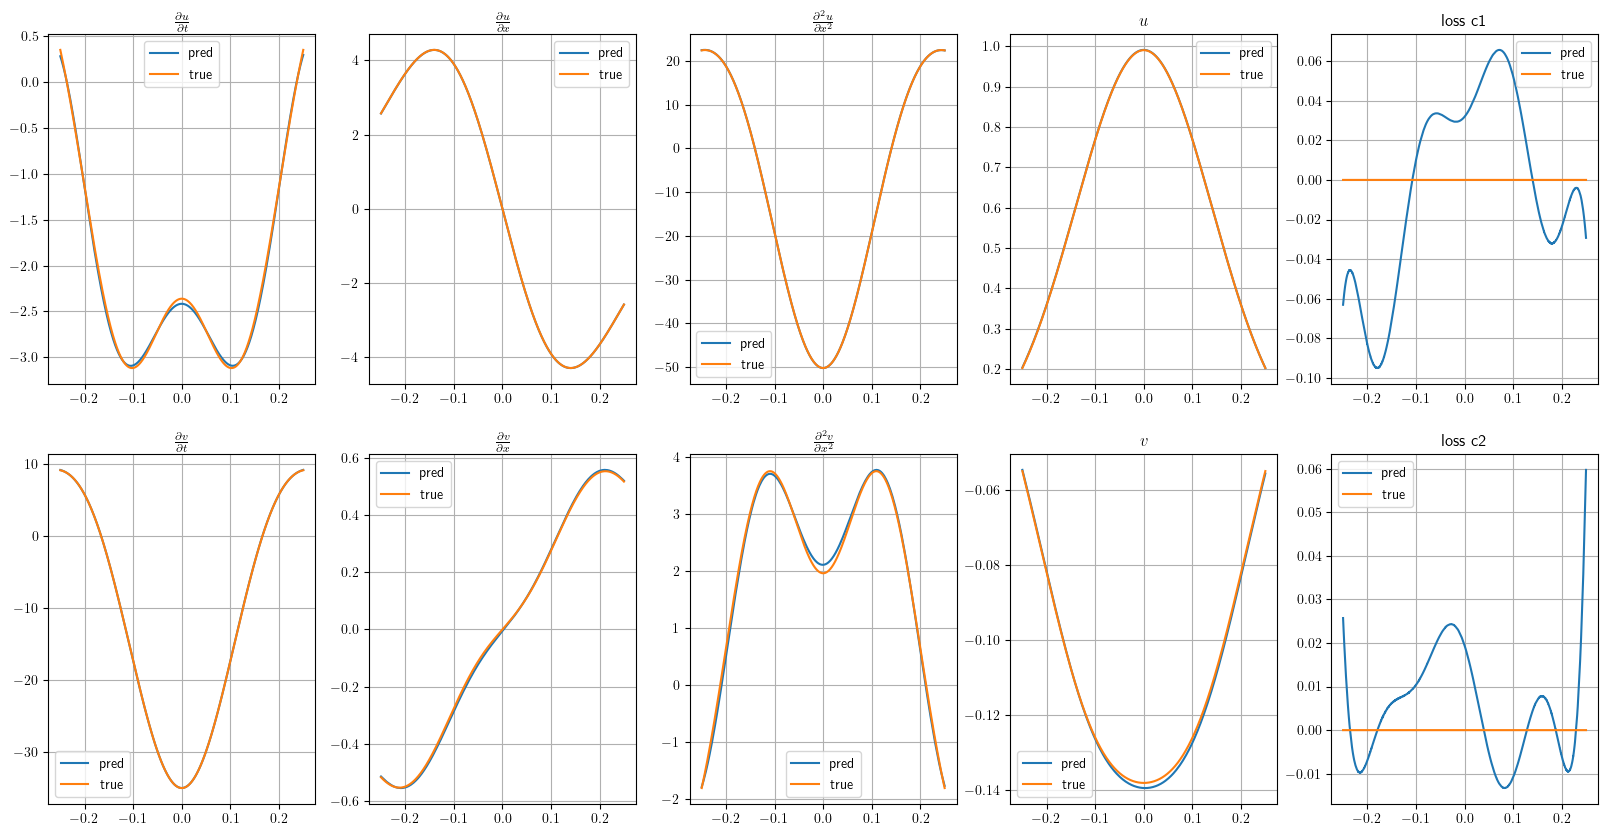

In [8]:
x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
t = jnp.zeros_like(x)
xt = jnp.hstack([x, t])


# direct_params_ = direct_params
direct_params_ = get_params(opt_state)
duv_dxt = jacobian(direct_params_, xt)
du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
duv_dxxtt = hessian(direct_params_, xt)
du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
uv = model(direct_params_, xt)
u, v = uv[:, 0:1], uv[:, 1:2]
loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["text.usetex"] = True

f, ax = plt.subplots(2, 5, figsize = (20, 10))
i, j = 0, 0
ax[i][j].plot(x, du_dt, label = "pred")
ax[i][j].plot(x, du0_dt, label = "true")
ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
i = 1
ax[i][j].plot(x, dv_dt, label = "pred")
ax[i][j].plot(x, dv0_dt, label = "true")
ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
i, j = 0, j+1
ax[i][j].plot(x, du_dx, label = "pred")
ax[i][j].plot(x, du0_dx, label = "true")
ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
i = 1
ax[i][j].plot(x, dv_dx, label = "pred")
ax[i][j].plot(x, dv0_dx, label = "true")
ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
i, j = 0, j+1
ax[i][j].plot(x, du_dxx, label = "pred")
ax[i][j].plot(x, du0_dxx, label = "true")
ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
i = 1
ax[i][j].plot(x, dv_dxx, label = "pred")
ax[i][j].plot(x, dv0_dxx, label = "true")
ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
i, j = 0, j+1
ax[i][j].plot(x, u, label = "pred")
ax[i][j].plot(x, u0, label = "true")
ax[i][j].set_title(r"$u$")
i = 1
ax[i][j].plot(x, v, label = "pred")
ax[i][j].plot(x, v0, label = "true")
ax[i][j].set_title(r"$v$")
i, j = 0, j+1
ax[i][j].plot(x, loss_c1, label = "pred")
ax[i][j].plot(x, loss_c10, label = "true")
ax[i][j].set_title(r"loss c1")
i = 1
ax[i][j].plot(x, loss_c2, label = "pred")
ax[i][j].plot(x, loss_c20, label = "true")
ax[i][j].set_title(r"loss c2")

for i in range(2):
	for j in range(5):
		ax[i][j].legend()
		ax[i][j].grid()
plt.show()

In [ ]:
get_params(opt_state)

In [ ]:
du_dxx

In [ ]:
du0_dx_fn(jnp.array([[-0.25, 0.0], [0.25, 0.0]]))